# Step 4: Exploratory Data Analysis

## Imports

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#### Load Spacy's Default Things

In [2]:
nlp = spacy.load('en_core_web_sm')
stop_words_spacy = set(nlp.Defaults.stop_words)

## Read-In Data

In [3]:
health = pd.read_csv('../data/womens_health.csv', index_col = 'Unnamed: 0')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy.csv', index_col = 'Unnamed: 0')
pospar = pd.read_csv('../data/postpartum.csv', index_col = 'Unnamed: 0')

## Check Head and Shape of Data

### General Women's Health Data

In [4]:
health.head(2)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Been to the clinic twice and they don’t know w...,So I’ve been having problems with discharge an...,WomensHealth,1596818251,thecrazedbunny,0,1,True,2020-08-07
1,Period going on for 14 days today. Help!!,Hi guys. I'm getting a bit worried about my pe...,WomensHealth,1596822599,Help-Me-Already,4,1,True,2020-08-07


In [5]:
health.shape

(31385, 9)

### Fertility and Pregnancy Data

In [6]:
obsgyn.head(2)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Adding to the kitchen sink approach: I just bo...,This time I’m going to be using a menstrual cu...,TryingForABaby,1596839749,lastput1,7,1,True,2020-08-07
1,Has anyone used/or currently an app to track t...,\nMy husband and I are new to TTC.\n\nWe have ...,TryingForABaby,1596841178,ParkingFrosting4,8,1,True,2020-08-07


In [7]:
obsgyn.shape

(98138, 9)

### Postpartum Data

In [8]:
pospar.head(2)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Question about bottles,I'm researching baby bottles and am trying to ...,BabyBumps,1596850138,All_Hail_CC,4,1,True,2020-08-07
1,Anyone else getting that generation gap judgem...,"Aunt- I don’t eat much meat, but when I was pr...",BabyBumps,1596850152,waterfallsummer,86,1,True,2020-08-07


In [9]:
pospar.shape

(51674, 9)

## Clean Columns

### Combine `title` and `selftext` columns into a `total_text` column

The format of a Reddit post consists of a post title (`title`), and there is also an opportunity to write a body of text (`selftext`). For this project, I will be interested in analyzing all text in a post, so I will combine all of the text into a `total_text` column.

In [10]:
def create_total_text(df):
    df['total_text'] = df['title'] + ' ' + df['selftext']
    df.drop(columns = ['title', 'selftext'], inplace = True)
    return df.head(1)

In [11]:
create_total_text(health)
create_total_text(obsgyn)
create_total_text(pospar)

,subreddit,created_utc,author,num_comments,score,is_self,timestamp,total_text
0,BabyBumps,1596850138,All_Hail_CC,4,1,True,2020-08-07,Question about bottles I'm researching baby bo...


### Drop Unnecessary Columns

For this project, I am interested in using topic modeling to identify areas of concern for each domain of women's health. Therefore, the number of comments and score of each post will not be relevant and will be removed. Because the date is included under `timestamp`, the `created_utc` column will also be removed. The `is_self` column is also not needed and will be removed.

In [12]:
def clean_columns(df):
    df.drop(columns = ['created_utc', 'num_comments', 'score', 'is_self'], inplace = True)
    return df.head(1)

In [13]:
clean_columns(health)
clean_columns(obsgyn)
clean_columns(pospar)

,subreddit,author,timestamp,total_text
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...


## Check for Null/Missing Values

In [14]:
def display_percent_null(df):
    '''Returns the percent of values in each column that are null or missing'''
    return (df.isna().sum()/len(df)) * 100

### Women's Health Data

In [15]:
display_percent_null(health)

subreddit     0.000000
author        0.000000
timestamp     0.000000
total_text    2.450215
dtype: float64

Approximately 2.5% of the posts do not have text in the body of the post. However, because these posts have titles, this will be okay.

### Pregnancy and Fertility Data

In [16]:
display_percent_null(obsgyn)

subreddit     0.000000
author        0.000000
timestamp     0.000000
total_text    1.566162
dtype: float64

Approximately 1.5% of posts in the pregnancy and fertility data frame are null or missing. Again, because all of these posts have text in the title, this will be okay.

### Postpartum Data

In [17]:
display_percent_null(pospar)

subreddit     0.000000
author        0.000000
timestamp     0.000000
total_text    1.563649
dtype: float64

Approximately 1.6% of posts in the postpartum data frame are null or missing. Again, because all of these posts have text in the title, this will be okay.

### Drop Missing Data

In [18]:
health.dropna(inplace = True)
obsgyn.dropna(inplace = True)
pospar.dropna(inplace = True)

## Check Data Typse

In [19]:
def convert_to_datetime(df, column):
    df[column] = pd.to_datetime(df[column])
    return df.dtypes

### Women's Health Data

In [20]:
health.dtypes

subreddit     object
author        object
timestamp     object
total_text    object
dtype: object

The `subreddit`, `author`, and `total_text` columns are the appropriate data type (strings), but the `timestamp` column should be converted to a datetime object.

In [21]:
convert_to_datetime(health, 'timestamp')

subreddit             object
author                object
timestamp     datetime64[ns]
total_text            object
dtype: object

### Fertility and Pregnancy Data

In [22]:
obsgyn.dtypes

subreddit     object
author        object
timestamp     object
total_text    object
dtype: object

Similar to the Women's Health Data, the `timestamp` column should be converted to a datetime object.

In [23]:
convert_to_datetime(obsgyn, 'timestamp')

subreddit             object
author                object
timestamp     datetime64[ns]
total_text            object
dtype: object

### Postpartum Data

In [24]:
pospar.dtypes

subreddit     object
author        object
timestamp     object
total_text    object
dtype: object

Similar to the Women's Health and Fertility and Pregnancy Data, the `timestamp` column should be converted to a datetime object.

In [25]:
convert_to_datetime(pospar, 'timestamp')

subreddit             object
author                object
timestamp     datetime64[ns]
total_text            object
dtype: object

## Remove Reddit-Specific and HTML Tags

In [26]:
def remove_string(df, column, string):
    df[column] = df[column].str.replace(string, '')
    return df.head(1)

#### [removed]
If moderators of the subreddit feel that the post violates one or more of the subreddit's rules, they will remove content of the post and replace it with a "[removed]" tag. Because the [removed] tags will not add any valuable information to the post, these will be removed from posts.

In [27]:
remove_string(health, 'total_text', '\[removed\]')
remove_string(obsgyn, 'total_text', '\[removed\]')
remove_string(pospar, 'total_text', '\[removed\]')

,subreddit,author,timestamp,total_text
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...


#### \n
This is a symbol that indicates a new line. Because we are only interested in the text itself, this tag will be removed.

In [28]:
remove_string(health, 'total_text', '\n')
remove_string(obsgyn, 'total_text', '\n')
remove_string(pospar, 'total_text', '\n')

,subreddit,author,timestamp,total_text
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...


#### &amp ;

Sometimes, the '&' symbol is not displayed, and the HTML reference `&amp;` shows up instead. This text will be removed.

In [29]:
remove_string(health, 'total_text', '&amp;')
remove_string(obsgyn, 'total_text', '&amp;')
remove_string(pospar, 'total_text', '&amp;')

,subreddit,author,timestamp,total_text
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...


#### &gt ;

Some times, the greater than symbol (>) is not properly displayed, and the HTML reference `&gt;` shows up in its place. I will remove this HTML reference.

In [30]:
remove_string(health, 'total_text', '&gt;')
remove_string(obsgyn, 'total_text', '&gt;')
remove_string(pospar, 'total_text', '&gt;')

,subreddit,author,timestamp,total_text
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...


#### &lt ;

Some times, the less than symbol (<) is not properly displayed, and the HTML reference `&lt;` shows up in its place. I will remove this HTML reference.

In [31]:
remove_string(health, 'total_text', '&lt;')
remove_string(obsgyn, 'total_text', '&lt;')
remove_string(pospar, 'total_text', '&lt;')

,subreddit,author,timestamp,total_text
0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...


#### TL;DR

In [209]:
remove_string(health, 'total_text', 'TL;DR')
remove_string(obsgyn, 'total_text', 'TL;DR')
remove_string(pospar, 'total_text', 'TL;DR')

,index,subreddit,author,timestamp,total_text,word_count,lemma_tokens,sentiment_score,negativity_score
0,0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...,43,question bottle -PRON- research baby bottle tr...,0.1779,0.05


### Remove Website URLs

#### Reset Indices

In [32]:
health.reset_index(inplace = True)
obsgyn.reset_index(inplace = True)
pospar.reset_index(inplace = True)

In [36]:
def remove_urls(df, column):
    for i in range(0, len(df)):
        df.loc[i, column] = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', df.loc[i, column])
        
# Regex Code by Lee Martin (Stack Overflow post)
# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/11332580        

In [37]:
remove_urls(health, 'total_text')

remove_urls(obsgyn, 'total_text')

remove_urls(pospar, 'total_text')

#### Check to see if removing URLs resulted in any null 'total_text'; If so, remove it.

In [40]:
def delete_empty_text(df, column):
    df = df[df[column] != '']
    return df.shape

In [41]:
delete_empty_text(health, 'total_text')
delete_empty_text(obsgyn, 'total_text')
delete_empty_text(pospar, 'total_text')

(30615, 5)

### Export Clean Data to CSV

In [44]:
health.to_csv('../data/womens_health_clean.csv', index = False)
obsgyn.to_csv('../data/fertility_and_pregnancy_clean.csv', index = False)
pospar.to_csv('../data/postpartum_clean.csv', index = False)

## Exploratory Data Analysis

#### Define Color Palette

In [45]:
blush = '#F7D1CD'
pink = '#E8C2CA'
light_purple = '#D1B3C4'
medium_purple = '#B392AC'
dark_purple = '#B392AC'
warm_grey = '#8E9AAF'

### How many unique authors are there per subject matter?

One of the reasons why we believe that using an online health forum to identify women's health concerns could be better than a focus group or targeted survey is because of the scope of people that we will be able to reach. Here, we will explore how many women voiced their concerns for each of the topics of interest.

If it appears that several users have authored multiple posts, I will also examine these posts to eliminate the chances of including advertisements or spam in my analyses.

In [46]:
def unique_authors(df, column, title):
    return f'{title} has {df[column].nunique()} unique authors.'

#### Women's Health

In [47]:
unique_authors(health, 'author', 'Women\'s Health')

"Women's Health has 19753 unique authors."

In terms of general women's health concerns, we have posts from 19,753 unique users. Because there are 31,385 total posts, this means that 11,361 posts were contributed by a duplicate user.

#### Fertility and Pregnancy

In [48]:
unique_authors(obsgyn, 'author', 'Fertility and Pregnancy')

'Fertility and Pregnancy has 35128 unique authors.'

The Fertility and Pregnancy data (`obsgyn`) has 98,138 total posts, but only 35,517 are unique. This means that 62,621 posts are by duplicate authors. 

#### Postpartum

In [49]:
unique_authors(pospar, 'author', 'Postpartum')

'Postpartum has 21586 unique authors.'

The postpartum data has posts that were authored by 21,821 unique users. Because there are 51,674 total posts in the data frame, this means that 29,853 posts are by duplicate authors. 

### Are there any duplicated posts?

Because the number of posts is larger than the number of authors, we can deduce that some users have posted on these subreddits more than one time. To eliminate counting the same post more than one time, I will check for duplicate posts and remove them from the data.

In [50]:
def check_for_duplicates(df, column):
    duplicates = df[df[column].duplicated() == True].copy()
    return duplicates.shape[0]

#### Women's Health Data

In [51]:
check_for_duplicates(health, 'total_text')

131

In [52]:
health['total_text'].drop_duplicates(inplace = True)

There were 131 duplicate posts in the women's health data that have been removed.

#### Fertility and Pregnancy Data

In [53]:
check_for_duplicates(obsgyn, 'total_text')

2191

In [54]:
obsgyn['total_text'].drop_duplicates(inplace = True)

There were 2190 duplicate posts in the fertility and pregnancy data that have been removed.

#### Postpartum Data

In [55]:
check_for_duplicates(pospar, 'total_text')

959

In [56]:
pospar['total_text'].drop_duplicates(inplace = True)

There were 959 duplicate posts in the pospartum data that have been removed.

### Reset Indices

In [57]:
health = health.reset_index(drop = True)
obsgyn = obsgyn.reset_index(drop = True)
pospar = pospar.reset_index(drop = True)

### Word Count Distributions

#### Get Word Counts for Posts in Each Data Set

In [58]:
def get_word_count(df, column, new_column = 'word_count'):
    df[new_column] = df[column].apply(lambda x: len(x.split()))
    return df.head(1)

In [59]:
get_word_count(health, 'total_text')

,index,subreddit,author,timestamp,total_text,word_count
0,0,WomensHealth,thecrazedbunny,2020-08-07,Been to the clinic twice and they don’t know w...,382


In [60]:
get_word_count(obsgyn, 'total_text')

,index,subreddit,author,timestamp,total_text,word_count
0,0,TryingForABaby,lastput1,2020-08-07,Adding to the kitchen sink approach: I just bo...,81


In [61]:
get_word_count(pospar, 'total_text')

,index,subreddit,author,timestamp,total_text,word_count
0,0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...,43


#### Visualize Word Count Distributions

In [62]:
def subplot_histogram(data, axis, title = None, x_label = None, y_label = None, color = None):
    sns.distplot(data, ax = axis, kde = False, hist_kws=dict(edgecolor="k", linewidth=.9, alpha = 0.9), color = color)
    axis.set_title(title, pad = 8, fontdict = {'fontsize':14})
    axis.set_xlabel(x_label, labelpad = 6, fontdict = {'fontsize':13})
    axis.set_ylabel(y_label, labelpad = 6, fontdict = {'fontsize':13})
    axis.tick_params(axis = 'both', labelsize = 11)
    plt.tight_layout();

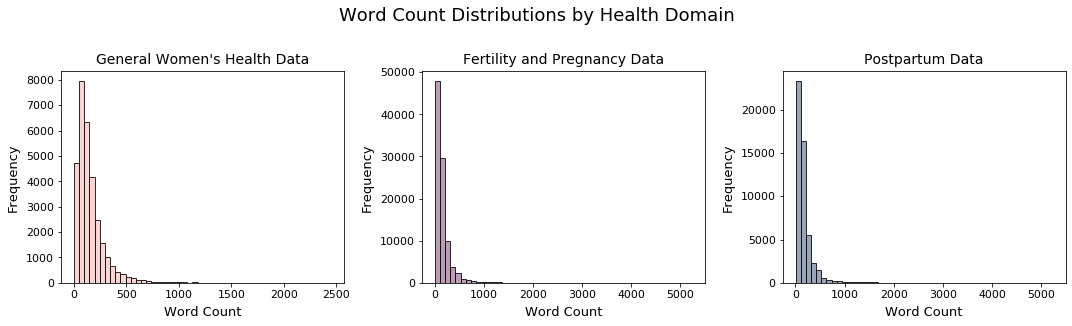

In [63]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))

ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

subplot_histogram(health['word_count'], 
                  axis = ax1,
                  title = 'General Women\'s Health Data',
                  x_label = 'Word Count',
                  y_label = 'Frequency',
                  color = blush )


subplot_histogram(obsgyn['word_count'], 
                  axis = ax2,
                  title = 'Fertility and Pregnancy Data',
                  x_label = 'Word Count',
                  y_label = 'Frequency',
                  color = dark_purple)

subplot_histogram(pospar['word_count'],
                  axis = ax3,
                  title = 'Postpartum Data',
                  x_label = 'Word Count',
                  y_label = 'Frequency',
                  color = warm_grey)

plt.suptitle('Word Count Distributions by Health Domain', y = 1.12, size = 18);

As shown in the histograms above, the majority of posts for all three health domains are less than 1000 words in length.

**General Women's Health Domain**: The average word count for the Women's Health domain was 154.5, but word counts ranged from 1 to 2453 words. Almost 75% of posts had word counts of 193 words or less. 

**Fertility and Pregnancy Domain**: The average word count for the Fertility and Pregnancy domain was 154.2 words, but word counts varied from 1 to 5238 words. Almost 75% of posts had word counts of 182 words or less.

**Postpartum Domain**: The average word count for the Postpartum domain is 169.8 words, but word counts range from 1 to 5238. Almost 75% of posts have word counts of 195 words or less.

### Visualizing Most Common Words and Bigrams

#### Functions

In [75]:
def get_word_vector(data, ngrams = (1,1), stopwords = None, min_df = 0.005):
    cvec = CountVectorizer(stop_words = stopwords, ngram_range = ngrams, min_df = min_df)
    words = cvec.fit_transform(data)
    df = pd.DataFrame(words.toarray(), columns = cvec.get_feature_names())
    return df

In [76]:
def get_word_sums(words_df):
    word_sum = {}
    for column in words_df.columns:
        word_sum[column] = words_df[column].sum()
    df = pd.DataFrame(sorted(word_sum.items(), key = lambda x: x[1], reverse = True), columns = ['Word', 'Count'])
    return df.sort_values('Count', ascending = False)

In [77]:
def plot_top_words(word_count_df, title = None, x_label = None, y_label = None, color = None, size = (18,10)):
    plt.figure(figsize = size)
    sns.barplot(x = word_count_df['Word'][:10], y = word_count_df['Count'][:10], color = color, edgecolor = 'black')
    plt.title(title, fontdict = {'fontsize':15}, pad = 12)
    plt.xlabel('Word', fontdict = {'fontsize':13}, labelpad = 10)
    plt.ylabel('Count', fontdict = {'fontsize':13}, labelpad = 10)
    plt.tight_layout;

#### Define Corpus

In [78]:
og_health_corpus = health['total_text'].copy()
og_obsgyn_corpus = obsgyn['total_text'].copy()
og_pospar_corpus = pospar['total_text'].copy()

### Most Frequent Words - Stop Words ***NOT*** Removed

In [79]:
# Create Bag of Words

og_health_words = get_word_vector(og_health_corpus)
og_obsgyn_words = get_word_vector(og_obsgyn_corpus)
og_pospar_words = get_word_vector(og_pospar_corpus)

In [80]:
# Count the Number of Times that Each Word Appears

og_health_word_counts = get_word_sums(og_health_words)
og_obsgyn_word_counts = get_word_sums(og_obsgyn_words)
og_pospar_word_counts = get_word_sums(og_pospar_words)

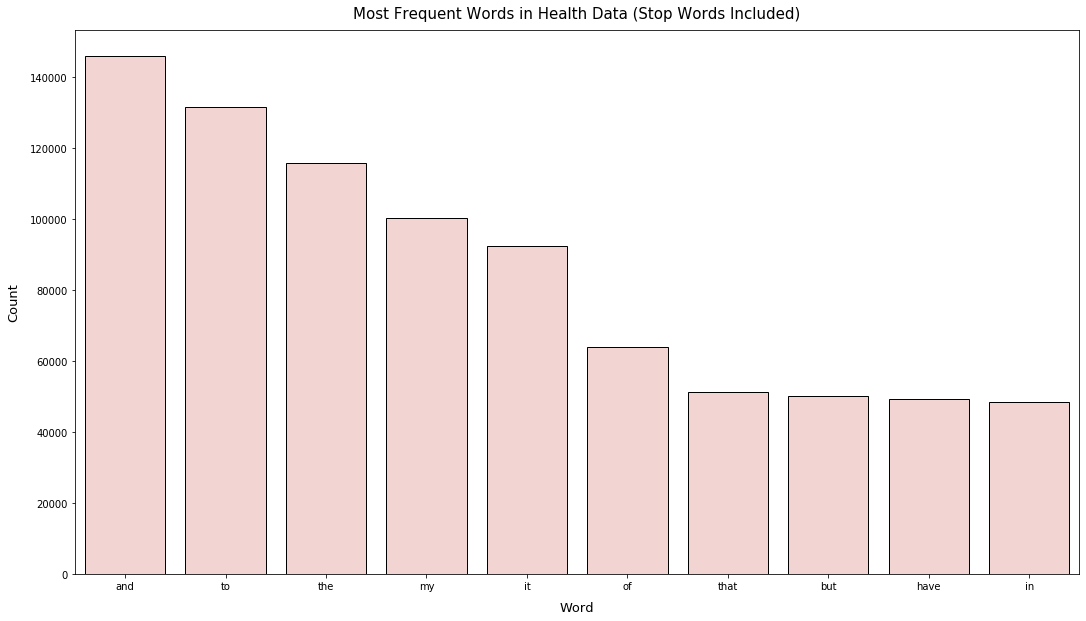

In [81]:
# Plot Top 10 Word Counts
plot_top_words(og_health_word_counts, 
               title = 'Most Frequent Words in Health Data (Stop Words Included)',
               color = blush)

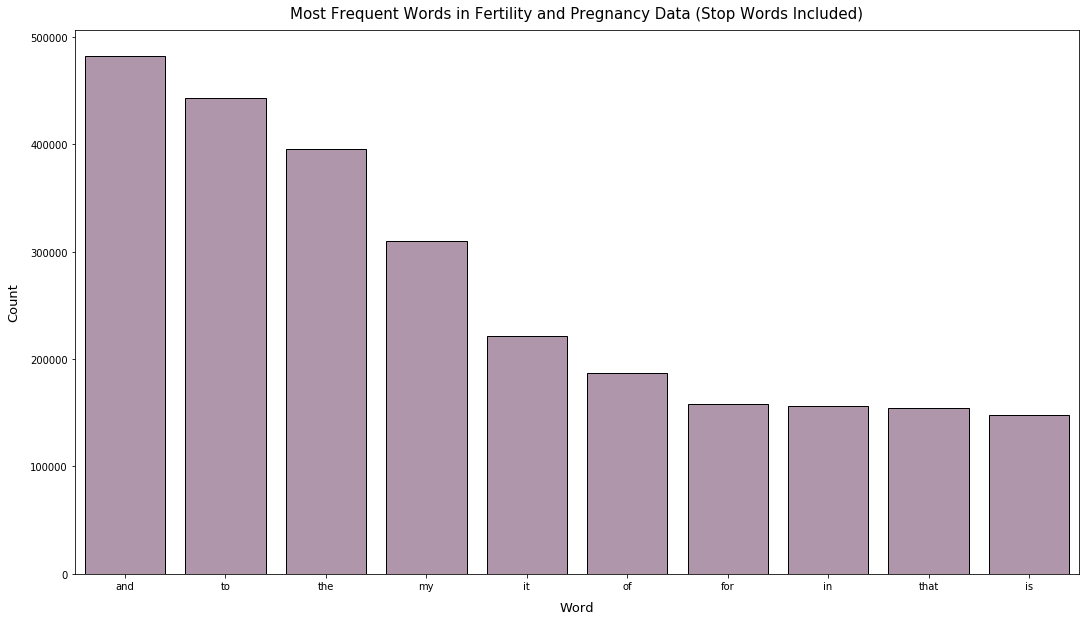

In [82]:
plot_top_words(og_obsgyn_word_counts, 
               title = 'Most Frequent Words in Fertility and Pregnancy Data (Stop Words Included)',
               color = dark_purple)

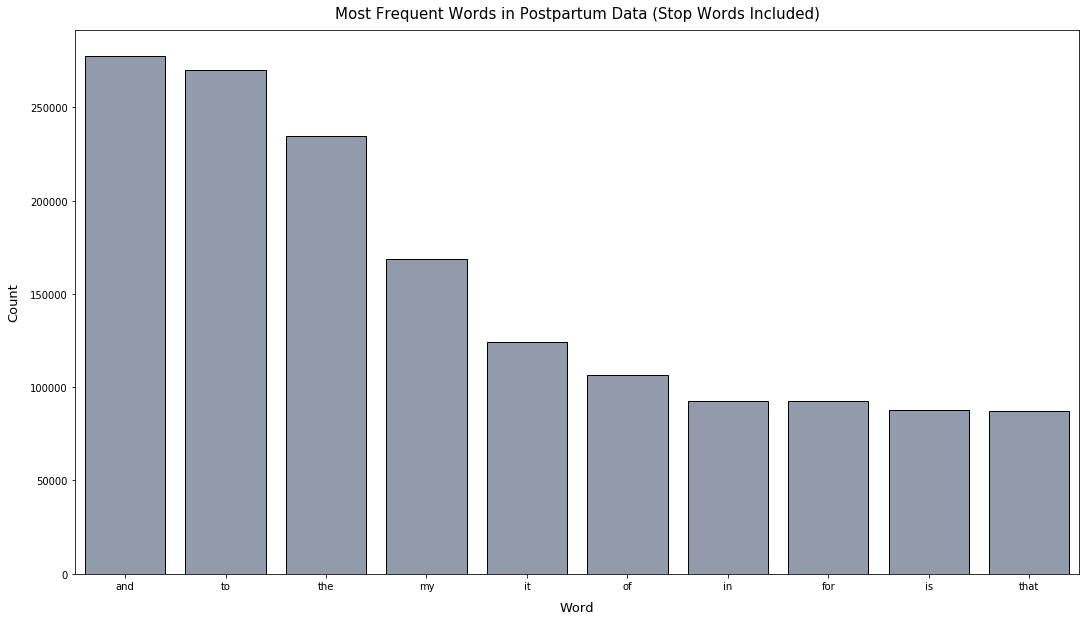

In [83]:
plot_top_words(og_pospar_word_counts, 
               title = 'Most Frequent Words in Postpartum Data (Stop Words Included)',
               color = warm_grey)

### Most Frequent Words by Data Set - Stopwords Removed

In [84]:
stop_words_nltk = set(stopwords.words('english'))
full_stop_words = stop_words_spacy.union(stop_words_nltk)

In [85]:
def add_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.add(word)

In [168]:
words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think', 'reddit', 'imgur', 'pron', 'officially']

add_stop_words(words_to_add, full_stop_words)

In [87]:
swr_health_words = get_word_vector(og_health_corpus, stopwords = full_stop_words)
swr_obsgyn_words = get_word_vector(og_obsgyn_corpus, stopwords = full_stop_words)
swr_pospar_words = get_word_vector(og_pospar_corpus, stopwords = full_stop_words)

In [88]:
swr_health_word_counts = get_word_sums(swr_health_words)
swr_obsgyn_word_counts = get_word_sums(swr_obsgyn_words)
swr_pospar_word_counts = get_word_sums(swr_pospar_words)

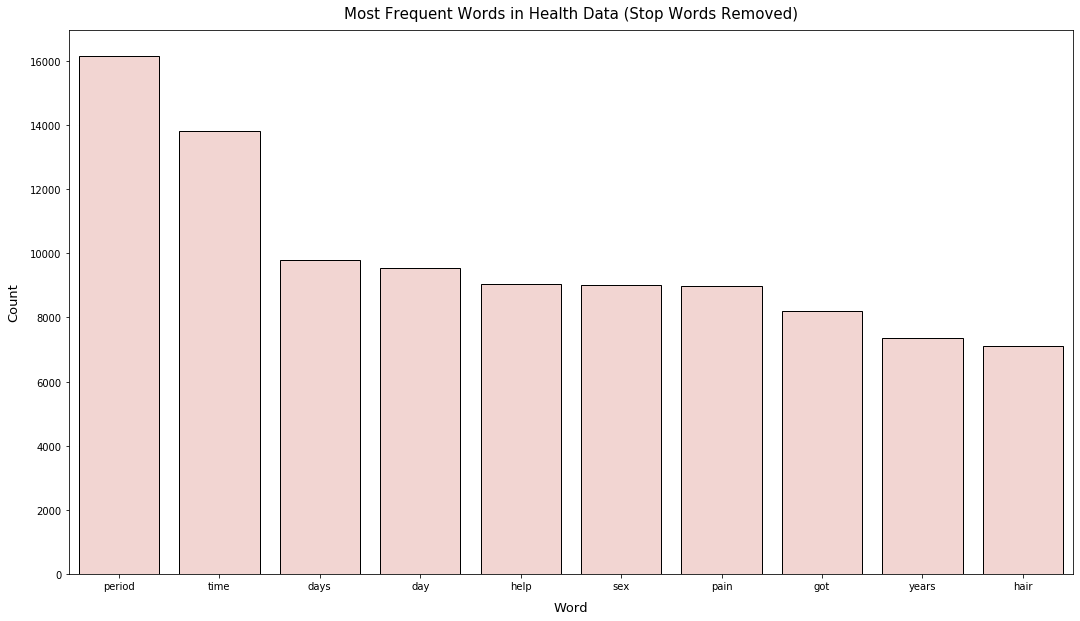

In [89]:
plot_top_words(swr_health_word_counts, 
               title = 'Most Frequent Words in Health Data (Stop Words Removed)',
               color = blush)

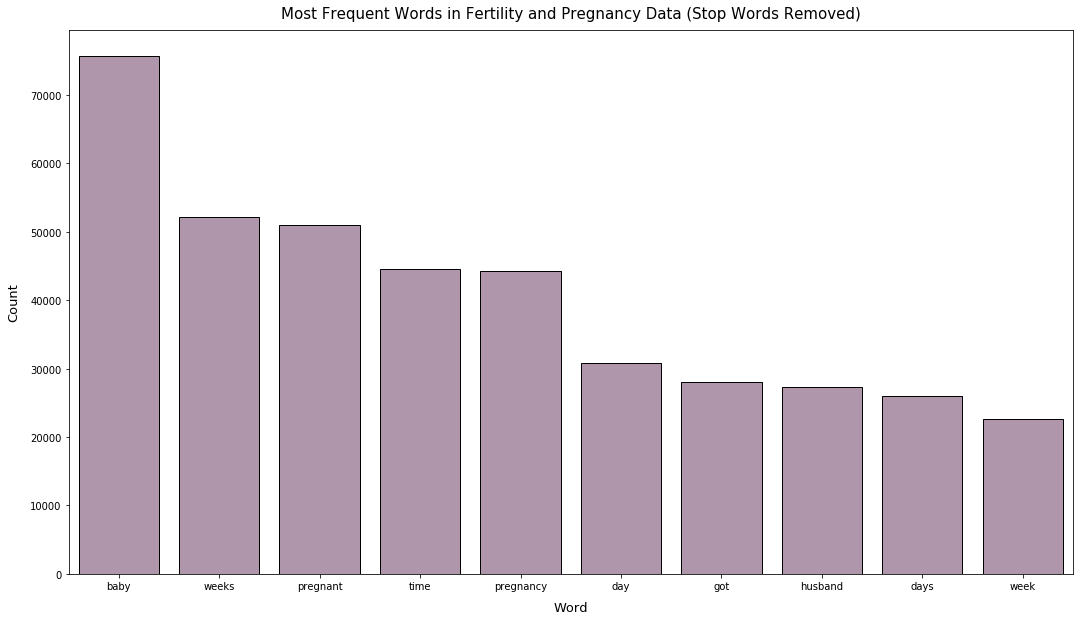

In [90]:
plot_top_words(swr_obsgyn_word_counts, 
               title = 'Most Frequent Words in Fertility and Pregnancy Data (Stop Words Removed)',
               color = dark_purple)

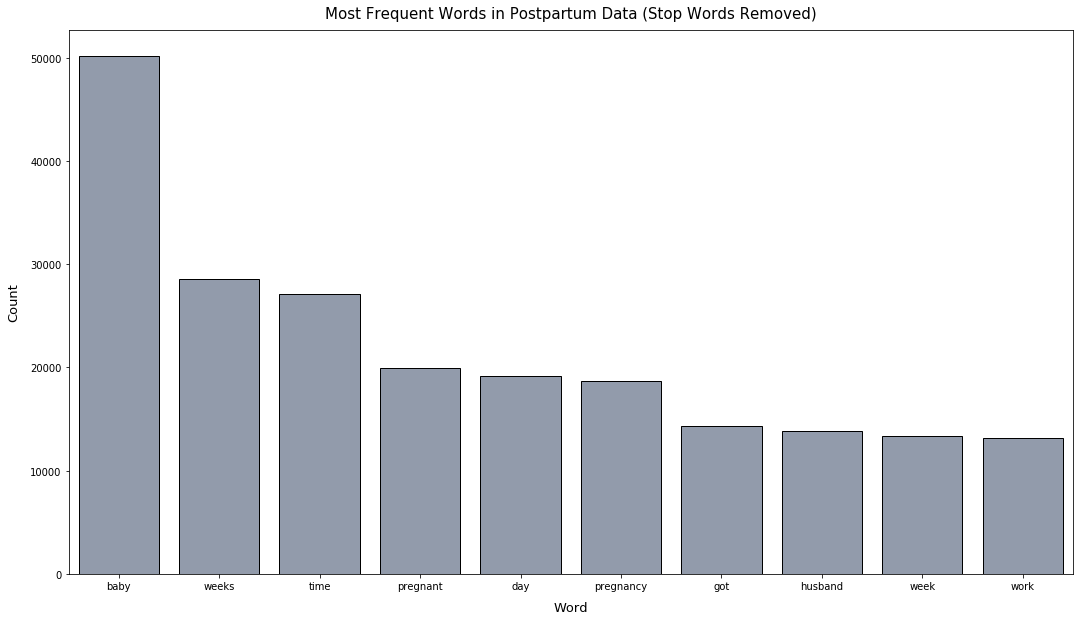

In [91]:
plot_top_words(swr_pospar_word_counts, 
               title = 'Most Frequent Words in Postpartum Data (Stop Words Removed)',
               color = warm_grey)

### Most Frequent Bigrams by Data Set - Stopwords Removed

In [114]:
swr_health_bigrams = get_word_vector(og_health_corpus, ngrams = (2,2), stopwords = full_stop_words)
swr_obsgyn_bigrams = get_word_vector(og_obsgyn_corpus, ngrams = (2,2), stopwords = full_stop_words)
swr_pospar_bigrams = get_word_vector(og_pospar_corpus, ngrams = (2,2), stopwords = full_stop_words)

In [115]:
swr_health_bigrams_counts = get_word_sums(swr_health_bigrams)
swr_obsgyn_bigrams_counts = get_word_sums(swr_obsgyn_bigrams)
swr_pospar_bigrams_counts = get_word_sums(swr_pospar_bigrams)

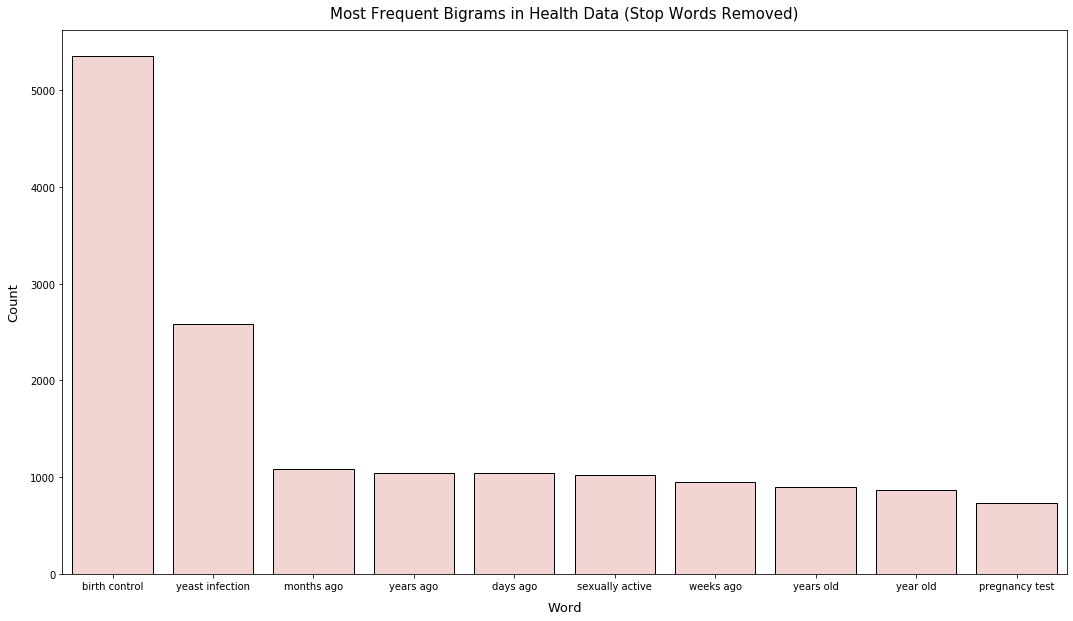

In [116]:
plot_top_words(swr_health_bigrams_counts, 
               title = 'Most Frequent Bigrams in Health Data (Stop Words Removed)',
               color = blush)

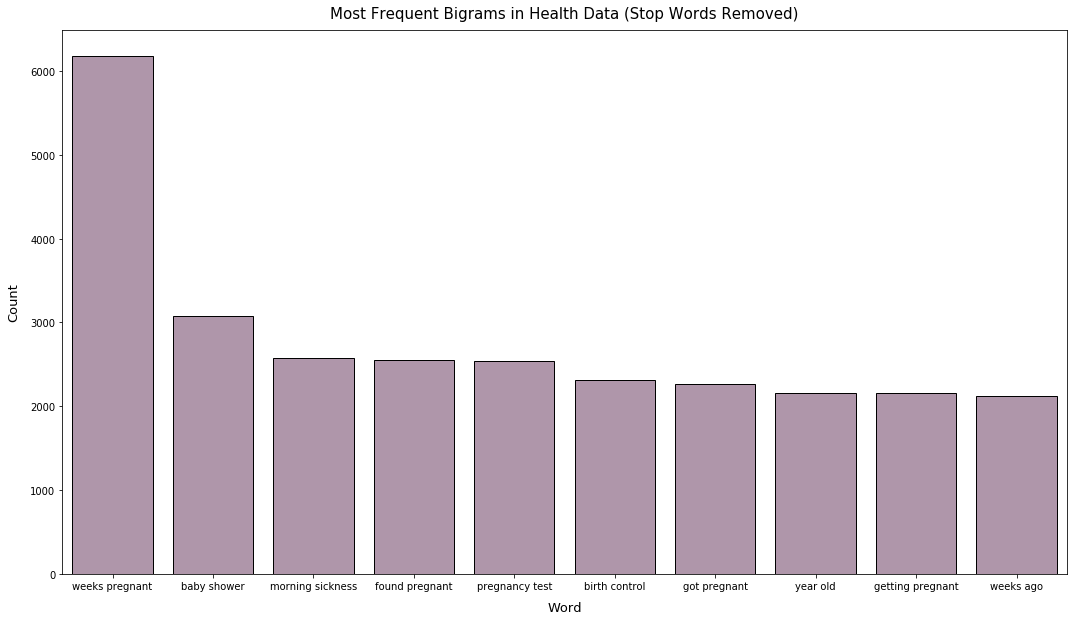

In [117]:
plot_top_words(swr_obsgyn_word_bigrams, 
               title = 'Most Frequent Bigrams in Health Data (Stop Words Removed)',
               color = dark_purple)

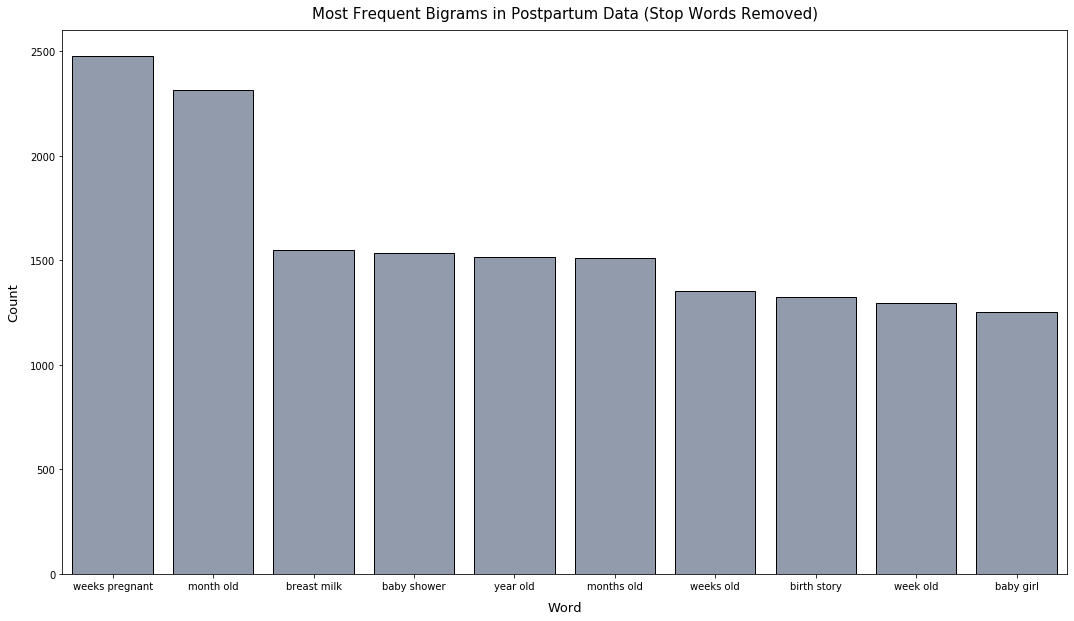

In [118]:
plot_top_words(swr_pospar_bigrams_counts, 
               title = 'Most Frequent Bigrams in Postpartum Data (Stop Words Removed)',
               color = warm_grey)

### Most Frequent Trigrams - Stop Words Removed

In [119]:
swr_health_trigrams = get_word_vector(og_health_corpus, ngrams = (3,3), stopwords = full_stop_words, min_df = 0.005)
swr_obsgyn_trigrams = get_word_vector(og_obsgyn_corpus, ngrams = (3,3), stopwords = full_stop_words, min_df = 0.005)
swr_pospar_trigrams = get_word_vector(og_pospar_corpus, ngrams = (3,3), stopwords = full_stop_words, min_df = 0.005)

In [120]:
swr_health_trigrams_counts = get_word_sums(swr_health_trigrams)
swr_obsgyn_trigrams_counts = get_word_sums(swr_obsgyn_trigrams)
swr_pospar_trigrams_counts = get_word_sums(swr_pospar_trigrams)

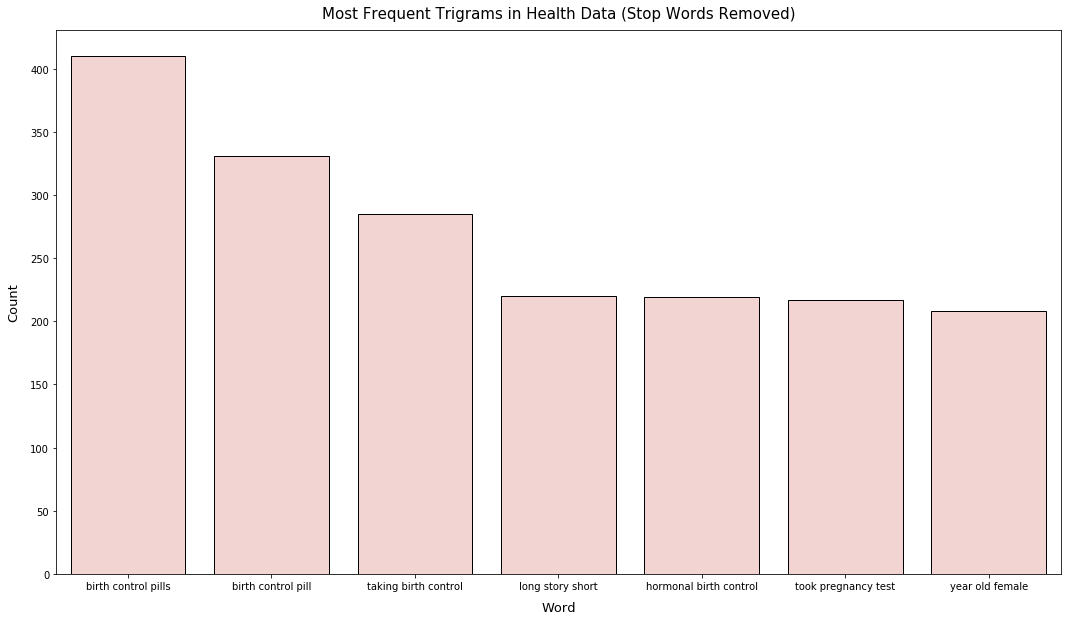

In [121]:
plot_top_words(swr_health_trigrams_counts, 
               title = 'Most Frequent Trigrams in Health Data (Stop Words Removed)',
               color = blush)

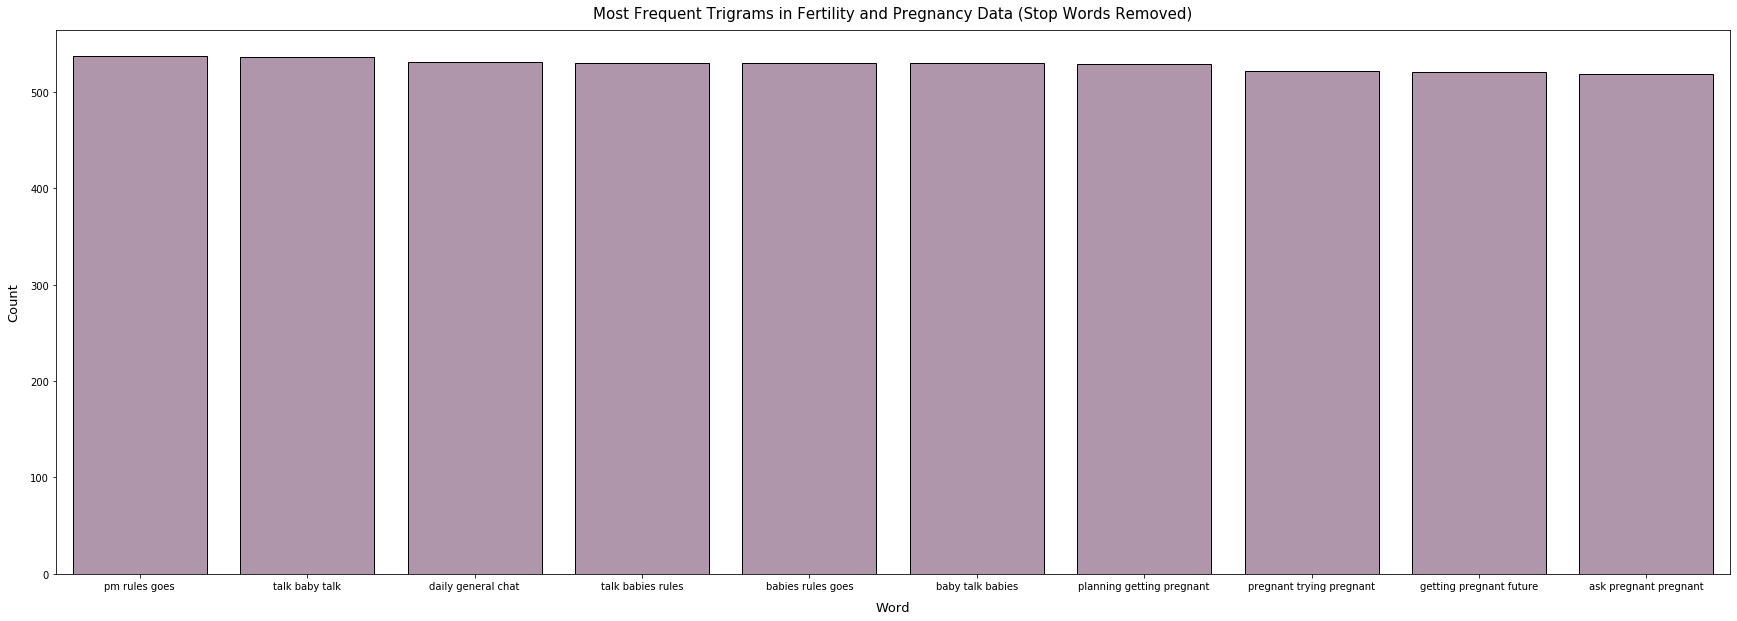

In [122]:
plot_top_words(swr_obsgyn_trigrams_counts, 
               title = 'Most Frequent Trigrams in Fertility and Pregnancy Data (Stop Words Removed)',
               color = dark_purple,
               size = (30, 10))

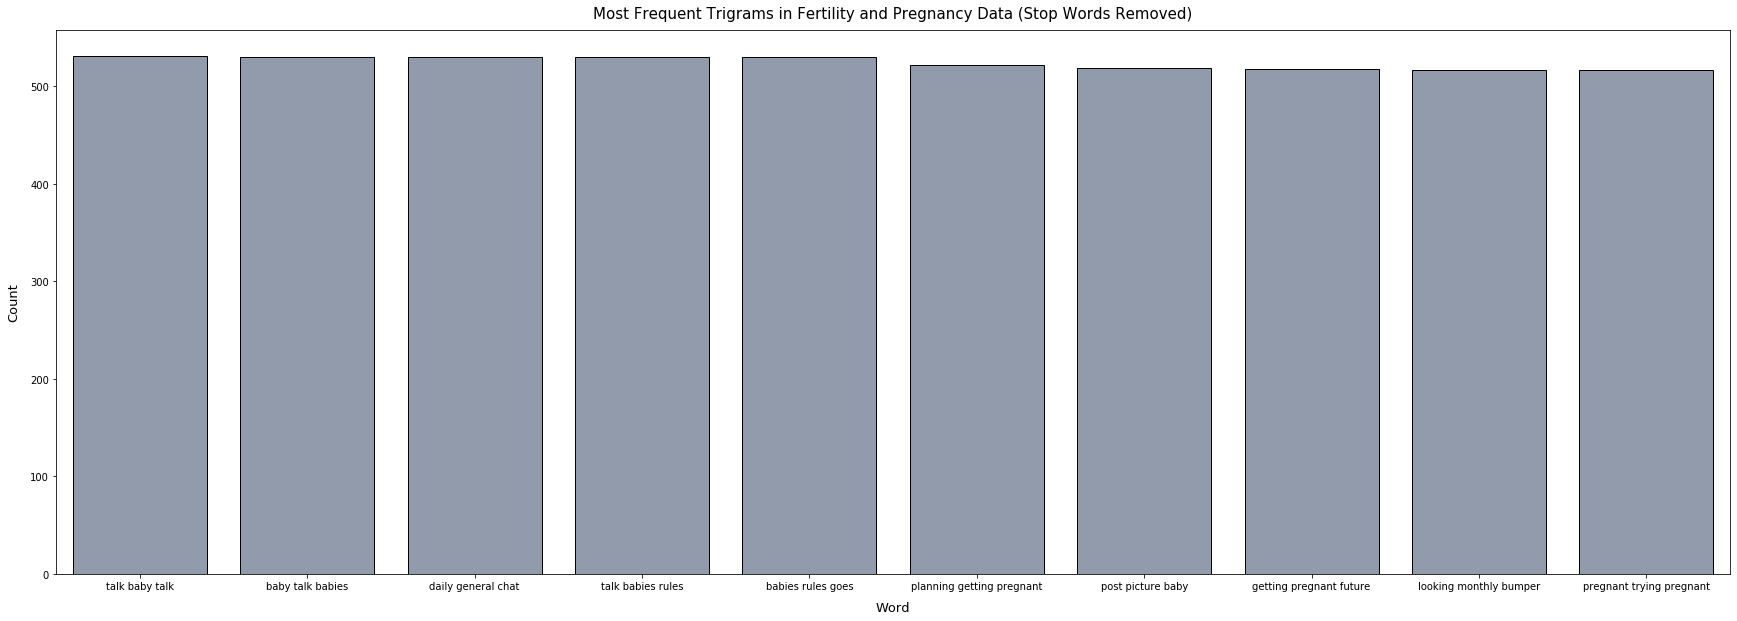

In [123]:
plot_top_words(swr_pospar_trigrams_counts, 
               title = 'Most Frequent Trigrams in Fertility and Pregnancy Data (Stop Words Removed)',
               color = warm_grey,
               size = (30, 10))

In [211]:
health['total_text'].shape

(30616,)

### EDA on Lemmatized Text

In [163]:
def tokenize_and_lemma(df, column, stop_words = full_stop_words):
    lemma_tokens = []
    counter = 0
    
    for post in df[column]:
        doc = nlp(post) # Run text through spaCy pipeline
        lemma_tokens.append([token.lemma_ for token in doc if token.text not in stop_words])
        counter += 1
        print(counter)

    df['lemma_tokens'] = [' '.join(post) for post in lemma_tokens] # join tokens back together into string
        
    return df.head()

In [159]:
tokenize_and_lemma(health, 'total_text')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069


3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720


5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368


6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007


8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654


10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
1025

11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
1163

12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
1299

14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
1436

15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
1574

16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
1712

18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
1849

19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
1987

21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
21233
21234
21235
21236
21237
21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
2124

22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
22603
22604
22605
22606
22607
22608
22609
22610
22611
22612
22613
22614
22615
2261

23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
2398

25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
2535

26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
2671

27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
28076
28077
28078
28079
28080
28081
28082
28083
28084
28085
28086
28087
28088
28089
28090
28091
28092
28093
28094
28095
28096
2809

29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461
29462
29463
29464
29465
29466
29467
29468
29469
2947

,index,subreddit,author,timestamp,total_text,word_count,lemma_tokens
0,0,WomensHealth,thecrazedbunny,2020-08-07,Been to the clinic twice and they don’t know w...,382,be clinic twice wrong . help ! so -PRON- probl...
1,1,WomensHealth,Help-Me-Already,2020-08-07,Period going on for 14 days today. Help!! Hi g...,200,period 14 day today . help ! ! hi guy . -PRON-...
2,2,WomensHealth,blueberrydoe,2020-08-07,Question about birth control - advice apprecia...,255,question birth control - advice appreciate ! h...
3,3,WomensHealth,TheTinyOne23,2020-08-07,Yeast infection vs. Cytolytic Vaginosis? Hi ev...,402,yeast infection vs. cytolytic Vaginosis ? hi !...
4,4,WomensHealth,BabyFaceIT,2020-08-07,Virgin concerned about transvaginal ultrasound...,83,Virgin concerned transvaginal ultrasound -PRON...
...,...,...,...,...,...,...,...
30611,23,TheGirlSurvivalGuide,SquirrelPrincess1629,2019-02-16,Struggling to hold it together My work situati...,171,struggle hold -PRON- work situation drive anxi...
30612,24,TheGirlSurvivalGuide,treclays,2019-02-16,How do you know what color to dye your hair? I...,107,how color dye hair ? -PRON- naturally brown ha...
30613,27,TheGirlSurvivalGuide,SimilarGift,2019-02-16,Conflicting views on sex :/ I think I have a r...,315,conflict view sex :/ -PRON- -PRON- strange vie...
30614,28,TheGirlSurvivalGuide,farmanimalsrock,2019-02-16,"Tight buffs, headbands, hats, etc. I am a fema...",162,"tight buff , headband , hat , etc . -PRON- fem..."


In [162]:
tokenize_and_lemma(obsgyn, 'total_text')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070


3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716


5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359


6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007


8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659


10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
1025

11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
1162

12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
1299

14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
1437

15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
1573

16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
1710

18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
1847

19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
1985

21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
2122

22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
2259

23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
2396

25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
2533

26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
2671

27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
28076
28077
28078
28079
28080
28081
28082
28083
28084
2808

29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
2945

30662
30663
30664
30665
30666
30667
30668
30669
30670
30671
30672
30673
30674
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
3082

32030
32031
32032
32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
32050
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060
32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
32073
32074
32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
32092
32093
32094
32095
32096
32097
32098
32099
32100
32101
32102
32103
32104
32105
32106
32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
3219

33396
33397
33398
33399
33400
33401
33402
33403
33404
33405
33406
33407
33408
33409
33410
33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428
33429
33430
33431
33432
33433
33434
33435
33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
3356

34771
34772
34773
34774
34775
34776
34777
34778
34779
34780
34781
34782
34783
34784
34785
34786
34787
34788
34789
34790
34791
34792
34793
34794
34795
34796
34797
34798
34799
34800
34801
34802
34803
34804
34805
34806
34807
34808
34809
34810
34811
34812
34813
34814
34815
34816
34817
34818
34819
34820
34821
34822
34823
34824
34825
34826
34827
34828
34829
34830
34831
34832
34833
34834
34835
34836
34837
34838
34839
34840
34841
34842
34843
34844
34845
34846
34847
34848
34849
34850
34851
34852
34853
34854
34855
34856
34857
34858
34859
34860
34861
34862
34863
34864
34865
34866
34867
34868
34869
34870
34871
34872
34873
34874
34875
34876
34877
34878
34879
34880
34881
34882
34883
34884
34885
34886
34887
34888
34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
3493

36139
36140
36141
36142
36143
36144
36145
36146
36147
36148
36149
36150
36151
36152
36153
36154
36155
36156
36157
36158
36159
36160
36161
36162
36163
36164
36165
36166
36167
36168
36169
36170
36171
36172
36173
36174
36175
36176
36177
36178
36179
36180
36181
36182
36183
36184
36185
36186
36187
36188
36189
36190
36191
36192
36193
36194
36195
36196
36197
36198
36199
36200
36201
36202
36203
36204
36205
36206
36207
36208
36209
36210
36211
36212
36213
36214
36215
36216
36217
36218
36219
36220
36221
36222
36223
36224
36225
36226
36227
36228
36229
36230
36231
36232
36233
36234
36235
36236
36237
36238
36239
36240
36241
36242
36243
36244
36245
36246
36247
36248
36249
36250
36251
36252
36253
36254
36255
36256
36257
36258
36259
36260
36261
36262
36263
36264
36265
36266
36267
36268
36269
36270
36271
36272
36273
36274
36275
36276
36277
36278
36279
36280
36281
36282
36283
36284
36285
36286
36287
36288
36289
36290
36291
36292
36293
36294
36295
36296
36297
36298
36299
36300
36301
36302
36303
36304
3630

37508
37509
37510
37511
37512
37513
37514
37515
37516
37517
37518
37519
37520
37521
37522
37523
37524
37525
37526
37527
37528
37529
37530
37531
37532
37533
37534
37535
37536
37537
37538
37539
37540
37541
37542
37543
37544
37545
37546
37547
37548
37549
37550
37551
37552
37553
37554
37555
37556
37557
37558
37559
37560
37561
37562
37563
37564
37565
37566
37567
37568
37569
37570
37571
37572
37573
37574
37575
37576
37577
37578
37579
37580
37581
37582
37583
37584
37585
37586
37587
37588
37589
37590
37591
37592
37593
37594
37595
37596
37597
37598
37599
37600
37601
37602
37603
37604
37605
37606
37607
37608
37609
37610
37611
37612
37613
37614
37615
37616
37617
37618
37619
37620
37621
37622
37623
37624
37625
37626
37627
37628
37629
37630
37631
37632
37633
37634
37635
37636
37637
37638
37639
37640
37641
37642
37643
37644
37645
37646
37647
37648
37649
37650
37651
37652
37653
37654
37655
37656
37657
37658
37659
37660
37661
37662
37663
37664
37665
37666
37667
37668
37669
37670
37671
37672
37673
3767

38890
38891
38892
38893
38894
38895
38896
38897
38898
38899
38900
38901
38902
38903
38904
38905
38906
38907
38908
38909
38910
38911
38912
38913
38914
38915
38916
38917
38918
38919
38920
38921
38922
38923
38924
38925
38926
38927
38928
38929
38930
38931
38932
38933
38934
38935
38936
38937
38938
38939
38940
38941
38942
38943
38944
38945
38946
38947
38948
38949
38950
38951
38952
38953
38954
38955
38956
38957
38958
38959
38960
38961
38962
38963
38964
38965
38966
38967
38968
38969
38970
38971
38972
38973
38974
38975
38976
38977
38978
38979
38980
38981
38982
38983
38984
38985
38986
38987
38988
38989
38990
38991
38992
38993
38994
38995
38996
38997
38998
38999
39000
39001
39002
39003
39004
39005
39006
39007
39008
39009
39010
39011
39012
39013
39014
39015
39016
39017
39018
39019
39020
39021
39022
39023
39024
39025
39026
39027
39028
39029
39030
39031
39032
39033
39034
39035
39036
39037
39038
39039
39040
39041
39042
39043
39044
39045
39046
39047
39048
39049
39050
39051
39052
39053
39054
39055
3905

40256
40257
40258
40259
40260
40261
40262
40263
40264
40265
40266
40267
40268
40269
40270
40271
40272
40273
40274
40275
40276
40277
40278
40279
40280
40281
40282
40283
40284
40285
40286
40287
40288
40289
40290
40291
40292
40293
40294
40295
40296
40297
40298
40299
40300
40301
40302
40303
40304
40305
40306
40307
40308
40309
40310
40311
40312
40313
40314
40315
40316
40317
40318
40319
40320
40321
40322
40323
40324
40325
40326
40327
40328
40329
40330
40331
40332
40333
40334
40335
40336
40337
40338
40339
40340
40341
40342
40343
40344
40345
40346
40347
40348
40349
40350
40351
40352
40353
40354
40355
40356
40357
40358
40359
40360
40361
40362
40363
40364
40365
40366
40367
40368
40369
40370
40371
40372
40373
40374
40375
40376
40377
40378
40379
40380
40381
40382
40383
40384
40385
40386
40387
40388
40389
40390
40391
40392
40393
40394
40395
40396
40397
40398
40399
40400
40401
40402
40403
40404
40405
40406
40407
40408
40409
40410
40411
40412
40413
40414
40415
40416
40417
40418
40419
40420
40421
4042

41629
41630
41631
41632
41633
41634
41635
41636
41637
41638
41639
41640
41641
41642
41643
41644
41645
41646
41647
41648
41649
41650
41651
41652
41653
41654
41655
41656
41657
41658
41659
41660
41661
41662
41663
41664
41665
41666
41667
41668
41669
41670
41671
41672
41673
41674
41675
41676
41677
41678
41679
41680
41681
41682
41683
41684
41685
41686
41687
41688
41689
41690
41691
41692
41693
41694
41695
41696
41697
41698
41699
41700
41701
41702
41703
41704
41705
41706
41707
41708
41709
41710
41711
41712
41713
41714
41715
41716
41717
41718
41719
41720
41721
41722
41723
41724
41725
41726
41727
41728
41729
41730
41731
41732
41733
41734
41735
41736
41737
41738
41739
41740
41741
41742
41743
41744
41745
41746
41747
41748
41749
41750
41751
41752
41753
41754
41755
41756
41757
41758
41759
41760
41761
41762
41763
41764
41765
41766
41767
41768
41769
41770
41771
41772
41773
41774
41775
41776
41777
41778
41779
41780
41781
41782
41783
41784
41785
41786
41787
41788
41789
41790
41791
41792
41793
41794
4179

43004
43005
43006
43007
43008
43009
43010
43011
43012
43013
43014
43015
43016
43017
43018
43019
43020
43021
43022
43023
43024
43025
43026
43027
43028
43029
43030
43031
43032
43033
43034
43035
43036
43037
43038
43039
43040
43041
43042
43043
43044
43045
43046
43047
43048
43049
43050
43051
43052
43053
43054
43055
43056
43057
43058
43059
43060
43061
43062
43063
43064
43065
43066
43067
43068
43069
43070
43071
43072
43073
43074
43075
43076
43077
43078
43079
43080
43081
43082
43083
43084
43085
43086
43087
43088
43089
43090
43091
43092
43093
43094
43095
43096
43097
43098
43099
43100
43101
43102
43103
43104
43105
43106
43107
43108
43109
43110
43111
43112
43113
43114
43115
43116
43117
43118
43119
43120
43121
43122
43123
43124
43125
43126
43127
43128
43129
43130
43131
43132
43133
43134
43135
43136
43137
43138
43139
43140
43141
43142
43143
43144
43145
43146
43147
43148
43149
43150
43151
43152
43153
43154
43155
43156
43157
43158
43159
43160
43161
43162
43163
43164
43165
43166
43167
43168
43169
4317

44378
44379
44380
44381
44382
44383
44384
44385
44386
44387
44388
44389
44390
44391
44392
44393
44394
44395
44396
44397
44398
44399
44400
44401
44402
44403
44404
44405
44406
44407
44408
44409
44410
44411
44412
44413
44414
44415
44416
44417
44418
44419
44420
44421
44422
44423
44424
44425
44426
44427
44428
44429
44430
44431
44432
44433
44434
44435
44436
44437
44438
44439
44440
44441
44442
44443
44444
44445
44446
44447
44448
44449
44450
44451
44452
44453
44454
44455
44456
44457
44458
44459
44460
44461
44462
44463
44464
44465
44466
44467
44468
44469
44470
44471
44472
44473
44474
44475
44476
44477
44478
44479
44480
44481
44482
44483
44484
44485
44486
44487
44488
44489
44490
44491
44492
44493
44494
44495
44496
44497
44498
44499
44500
44501
44502
44503
44504
44505
44506
44507
44508
44509
44510
44511
44512
44513
44514
44515
44516
44517
44518
44519
44520
44521
44522
44523
44524
44525
44526
44527
44528
44529
44530
44531
44532
44533
44534
44535
44536
44537
44538
44539
44540
44541
44542
44543
4454

45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
45762
45763
45764
45765
45766
45767
45768
45769
45770
45771
45772
45773
45774
45775
45776
45777
45778
45779
45780
45781
45782
45783
45784
45785
45786
45787
45788
45789
45790
45791
45792
45793
45794
45795
45796
45797
45798
45799
45800
45801
45802
45803
45804
45805
45806
45807
45808
45809
45810
45811
45812
45813
45814
45815
45816
45817
45818
45819
45820
45821
45822
45823
45824
45825
45826
45827
45828
45829
45830
45831
45832
45833
45834
45835
45836
45837
45838
45839
45840
45841
45842
45843
45844
45845
45846
45847
45848
45849
45850
45851
45852
45853
45854
45855
45856
45857
45858
45859
45860
45861
45862
45863
45864
45865
45866
45867
45868
45869
45870
45871
45872
45873
45874
45875
45876
45877
45878
45879
45880
45881
45882
45883
45884
45885
45886
45887
45888
45889
45890
45891
45892
45893
45894
45895
45896
45897
45898
45899
45900
45901
45902
45903
45904
45905
45906
45907
45908
45909
45910
45911
45912
45913
4591

47114
47115
47116
47117
47118
47119
47120
47121
47122
47123
47124
47125
47126
47127
47128
47129
47130
47131
47132
47133
47134
47135
47136
47137
47138
47139
47140
47141
47142
47143
47144
47145
47146
47147
47148
47149
47150
47151
47152
47153
47154
47155
47156
47157
47158
47159
47160
47161
47162
47163
47164
47165
47166
47167
47168
47169
47170
47171
47172
47173
47174
47175
47176
47177
47178
47179
47180
47181
47182
47183
47184
47185
47186
47187
47188
47189
47190
47191
47192
47193
47194
47195
47196
47197
47198
47199
47200
47201
47202
47203
47204
47205
47206
47207
47208
47209
47210
47211
47212
47213
47214
47215
47216
47217
47218
47219
47220
47221
47222
47223
47224
47225
47226
47227
47228
47229
47230
47231
47232
47233
47234
47235
47236
47237
47238
47239
47240
47241
47242
47243
47244
47245
47246
47247
47248
47249
47250
47251
47252
47253
47254
47255
47256
47257
47258
47259
47260
47261
47262
47263
47264
47265
47266
47267
47268
47269
47270
47271
47272
47273
47274
47275
47276
47277
47278
47279
4728

48488
48489
48490
48491
48492
48493
48494
48495
48496
48497
48498
48499
48500
48501
48502
48503
48504
48505
48506
48507
48508
48509
48510
48511
48512
48513
48514
48515
48516
48517
48518
48519
48520
48521
48522
48523
48524
48525
48526
48527
48528
48529
48530
48531
48532
48533
48534
48535
48536
48537
48538
48539
48540
48541
48542
48543
48544
48545
48546
48547
48548
48549
48550
48551
48552
48553
48554
48555
48556
48557
48558
48559
48560
48561
48562
48563
48564
48565
48566
48567
48568
48569
48570
48571
48572
48573
48574
48575
48576
48577
48578
48579
48580
48581
48582
48583
48584
48585
48586
48587
48588
48589
48590
48591
48592
48593
48594
48595
48596
48597
48598
48599
48600
48601
48602
48603
48604
48605
48606
48607
48608
48609
48610
48611
48612
48613
48614
48615
48616
48617
48618
48619
48620
48621
48622
48623
48624
48625
48626
48627
48628
48629
48630
48631
48632
48633
48634
48635
48636
48637
48638
48639
48640
48641
48642
48643
48644
48645
48646
48647
48648
48649
48650
48651
48652
48653
4865

49861
49862
49863
49864
49865
49866
49867
49868
49869
49870
49871
49872
49873
49874
49875
49876
49877
49878
49879
49880
49881
49882
49883
49884
49885
49886
49887
49888
49889
49890
49891
49892
49893
49894
49895
49896
49897
49898
49899
49900
49901
49902
49903
49904
49905
49906
49907
49908
49909
49910
49911
49912
49913
49914
49915
49916
49917
49918
49919
49920
49921
49922
49923
49924
49925
49926
49927
49928
49929
49930
49931
49932
49933
49934
49935
49936
49937
49938
49939
49940
49941
49942
49943
49944
49945
49946
49947
49948
49949
49950
49951
49952
49953
49954
49955
49956
49957
49958
49959
49960
49961
49962
49963
49964
49965
49966
49967
49968
49969
49970
49971
49972
49973
49974
49975
49976
49977
49978
49979
49980
49981
49982
49983
49984
49985
49986
49987
49988
49989
49990
49991
49992
49993
49994
49995
49996
49997
49998
49999
50000
50001
50002
50003
50004
50005
50006
50007
50008
50009
50010
50011
50012
50013
50014
50015
50016
50017
50018
50019
50020
50021
50022
50023
50024
50025
50026
5002

51231
51232
51233
51234
51235
51236
51237
51238
51239
51240
51241
51242
51243
51244
51245
51246
51247
51248
51249
51250
51251
51252
51253
51254
51255
51256
51257
51258
51259
51260
51261
51262
51263
51264
51265
51266
51267
51268
51269
51270
51271
51272
51273
51274
51275
51276
51277
51278
51279
51280
51281
51282
51283
51284
51285
51286
51287
51288
51289
51290
51291
51292
51293
51294
51295
51296
51297
51298
51299
51300
51301
51302
51303
51304
51305
51306
51307
51308
51309
51310
51311
51312
51313
51314
51315
51316
51317
51318
51319
51320
51321
51322
51323
51324
51325
51326
51327
51328
51329
51330
51331
51332
51333
51334
51335
51336
51337
51338
51339
51340
51341
51342
51343
51344
51345
51346
51347
51348
51349
51350
51351
51352
51353
51354
51355
51356
51357
51358
51359
51360
51361
51362
51363
51364
51365
51366
51367
51368
51369
51370
51371
51372
51373
51374
51375
51376
51377
51378
51379
51380
51381
51382
51383
51384
51385
51386
51387
51388
51389
51390
51391
51392
51393
51394
51395
51396
5139

52606
52607
52608
52609
52610
52611
52612
52613
52614
52615
52616
52617
52618
52619
52620
52621
52622
52623
52624
52625
52626
52627
52628
52629
52630
52631
52632
52633
52634
52635
52636
52637
52638
52639
52640
52641
52642
52643
52644
52645
52646
52647
52648
52649
52650
52651
52652
52653
52654
52655
52656
52657
52658
52659
52660
52661
52662
52663
52664
52665
52666
52667
52668
52669
52670
52671
52672
52673
52674
52675
52676
52677
52678
52679
52680
52681
52682
52683
52684
52685
52686
52687
52688
52689
52690
52691
52692
52693
52694
52695
52696
52697
52698
52699
52700
52701
52702
52703
52704
52705
52706
52707
52708
52709
52710
52711
52712
52713
52714
52715
52716
52717
52718
52719
52720
52721
52722
52723
52724
52725
52726
52727
52728
52729
52730
52731
52732
52733
52734
52735
52736
52737
52738
52739
52740
52741
52742
52743
52744
52745
52746
52747
52748
52749
52750
52751
52752
52753
52754
52755
52756
52757
52758
52759
52760
52761
52762
52763
52764
52765
52766
52767
52768
52769
52770
52771
5277

53978
53979
53980
53981
53982
53983
53984
53985
53986
53987
53988
53989
53990
53991
53992
53993
53994
53995
53996
53997
53998
53999
54000
54001
54002
54003
54004
54005
54006
54007
54008
54009
54010
54011
54012
54013
54014
54015
54016
54017
54018
54019
54020
54021
54022
54023
54024
54025
54026
54027
54028
54029
54030
54031
54032
54033
54034
54035
54036
54037
54038
54039
54040
54041
54042
54043
54044
54045
54046
54047
54048
54049
54050
54051
54052
54053
54054
54055
54056
54057
54058
54059
54060
54061
54062
54063
54064
54065
54066
54067
54068
54069
54070
54071
54072
54073
54074
54075
54076
54077
54078
54079
54080
54081
54082
54083
54084
54085
54086
54087
54088
54089
54090
54091
54092
54093
54094
54095
54096
54097
54098
54099
54100
54101
54102
54103
54104
54105
54106
54107
54108
54109
54110
54111
54112
54113
54114
54115
54116
54117
54118
54119
54120
54121
54122
54123
54124
54125
54126
54127
54128
54129
54130
54131
54132
54133
54134
54135
54136
54137
54138
54139
54140
54141
54142
54143
5414

55353
55354
55355
55356
55357
55358
55359
55360
55361
55362
55363
55364
55365
55366
55367
55368
55369
55370
55371
55372
55373
55374
55375
55376
55377
55378
55379
55380
55381
55382
55383
55384
55385
55386
55387
55388
55389
55390
55391
55392
55393
55394
55395
55396
55397
55398
55399
55400
55401
55402
55403
55404
55405
55406
55407
55408
55409
55410
55411
55412
55413
55414
55415
55416
55417
55418
55419
55420
55421
55422
55423
55424
55425
55426
55427
55428
55429
55430
55431
55432
55433
55434
55435
55436
55437
55438
55439
55440
55441
55442
55443
55444
55445
55446
55447
55448
55449
55450
55451
55452
55453
55454
55455
55456
55457
55458
55459
55460
55461
55462
55463
55464
55465
55466
55467
55468
55469
55470
55471
55472
55473
55474
55475
55476
55477
55478
55479
55480
55481
55482
55483
55484
55485
55486
55487
55488
55489
55490
55491
55492
55493
55494
55495
55496
55497
55498
55499
55500
55501
55502
55503
55504
55505
55506
55507
55508
55509
55510
55511
55512
55513
55514
55515
55516
55517
55518
5551

56729
56730
56731
56732
56733
56734
56735
56736
56737
56738
56739
56740
56741
56742
56743
56744
56745
56746
56747
56748
56749
56750
56751
56752
56753
56754
56755
56756
56757
56758
56759
56760
56761
56762
56763
56764
56765
56766
56767
56768
56769
56770
56771
56772
56773
56774
56775
56776
56777
56778
56779
56780
56781
56782
56783
56784
56785
56786
56787
56788
56789
56790
56791
56792
56793
56794
56795
56796
56797
56798
56799
56800
56801
56802
56803
56804
56805
56806
56807
56808
56809
56810
56811
56812
56813
56814
56815
56816
56817
56818
56819
56820
56821
56822
56823
56824
56825
56826
56827
56828
56829
56830
56831
56832
56833
56834
56835
56836
56837
56838
56839
56840
56841
56842
56843
56844
56845
56846
56847
56848
56849
56850
56851
56852
56853
56854
56855
56856
56857
56858
56859
56860
56861
56862
56863
56864
56865
56866
56867
56868
56869
56870
56871
56872
56873
56874
56875
56876
56877
56878
56879
56880
56881
56882
56883
56884
56885
56886
56887
56888
56889
56890
56891
56892
56893
56894
5689

58102
58103
58104
58105
58106
58107
58108
58109
58110
58111
58112
58113
58114
58115
58116
58117
58118
58119
58120
58121
58122
58123
58124
58125
58126
58127
58128
58129
58130
58131
58132
58133
58134
58135
58136
58137
58138
58139
58140
58141
58142
58143
58144
58145
58146
58147
58148
58149
58150
58151
58152
58153
58154
58155
58156
58157
58158
58159
58160
58161
58162
58163
58164
58165
58166
58167
58168
58169
58170
58171
58172
58173
58174
58175
58176
58177
58178
58179
58180
58181
58182
58183
58184
58185
58186
58187
58188
58189
58190
58191
58192
58193
58194
58195
58196
58197
58198
58199
58200
58201
58202
58203
58204
58205
58206
58207
58208
58209
58210
58211
58212
58213
58214
58215
58216
58217
58218
58219
58220
58221
58222
58223
58224
58225
58226
58227
58228
58229
58230
58231
58232
58233
58234
58235
58236
58237
58238
58239
58240
58241
58242
58243
58244
58245
58246
58247
58248
58249
58250
58251
58252
58253
58254
58255
58256
58257
58258
58259
58260
58261
58262
58263
58264
58265
58266
58267
5826

59469
59470
59471
59472
59473
59474
59475
59476
59477
59478
59479
59480
59481
59482
59483
59484
59485
59486
59487
59488
59489
59490
59491
59492
59493
59494
59495
59496
59497
59498
59499
59500
59501
59502
59503
59504
59505
59506
59507
59508
59509
59510
59511
59512
59513
59514
59515
59516
59517
59518
59519
59520
59521
59522
59523
59524
59525
59526
59527
59528
59529
59530
59531
59532
59533
59534
59535
59536
59537
59538
59539
59540
59541
59542
59543
59544
59545
59546
59547
59548
59549
59550
59551
59552
59553
59554
59555
59556
59557
59558
59559
59560
59561
59562
59563
59564
59565
59566
59567
59568
59569
59570
59571
59572
59573
59574
59575
59576
59577
59578
59579
59580
59581
59582
59583
59584
59585
59586
59587
59588
59589
59590
59591
59592
59593
59594
59595
59596
59597
59598
59599
59600
59601
59602
59603
59604
59605
59606
59607
59608
59609
59610
59611
59612
59613
59614
59615
59616
59617
59618
59619
59620
59621
59622
59623
59624
59625
59626
59627
59628
59629
59630
59631
59632
59633
59634
5963

60842
60843
60844
60845
60846
60847
60848
60849
60850
60851
60852
60853
60854
60855
60856
60857
60858
60859
60860
60861
60862
60863
60864
60865
60866
60867
60868
60869
60870
60871
60872
60873
60874
60875
60876
60877
60878
60879
60880
60881
60882
60883
60884
60885
60886
60887
60888
60889
60890
60891
60892
60893
60894
60895
60896
60897
60898
60899
60900
60901
60902
60903
60904
60905
60906
60907
60908
60909
60910
60911
60912
60913
60914
60915
60916
60917
60918
60919
60920
60921
60922
60923
60924
60925
60926
60927
60928
60929
60930
60931
60932
60933
60934
60935
60936
60937
60938
60939
60940
60941
60942
60943
60944
60945
60946
60947
60948
60949
60950
60951
60952
60953
60954
60955
60956
60957
60958
60959
60960
60961
60962
60963
60964
60965
60966
60967
60968
60969
60970
60971
60972
60973
60974
60975
60976
60977
60978
60979
60980
60981
60982
60983
60984
60985
60986
60987
60988
60989
60990
60991
60992
60993
60994
60995
60996
60997
60998
60999
61000
61001
61002
61003
61004
61005
61006
61007
6100

62209
62210
62211
62212
62213
62214
62215
62216
62217
62218
62219
62220
62221
62222
62223
62224
62225
62226
62227
62228
62229
62230
62231
62232
62233
62234
62235
62236
62237
62238
62239
62240
62241
62242
62243
62244
62245
62246
62247
62248
62249
62250
62251
62252
62253
62254
62255
62256
62257
62258
62259
62260
62261
62262
62263
62264
62265
62266
62267
62268
62269
62270
62271
62272
62273
62274
62275
62276
62277
62278
62279
62280
62281
62282
62283
62284
62285
62286
62287
62288
62289
62290
62291
62292
62293
62294
62295
62296
62297
62298
62299
62300
62301
62302
62303
62304
62305
62306
62307
62308
62309
62310
62311
62312
62313
62314
62315
62316
62317
62318
62319
62320
62321
62322
62323
62324
62325
62326
62327
62328
62329
62330
62331
62332
62333
62334
62335
62336
62337
62338
62339
62340
62341
62342
62343
62344
62345
62346
62347
62348
62349
62350
62351
62352
62353
62354
62355
62356
62357
62358
62359
62360
62361
62362
62363
62364
62365
62366
62367
62368
62369
62370
62371
62372
62373
62374
6237

63583
63584
63585
63586
63587
63588
63589
63590
63591
63592
63593
63594
63595
63596
63597
63598
63599
63600
63601
63602
63603
63604
63605
63606
63607
63608
63609
63610
63611
63612
63613
63614
63615
63616
63617
63618
63619
63620
63621
63622
63623
63624
63625
63626
63627
63628
63629
63630
63631
63632
63633
63634
63635
63636
63637
63638
63639
63640
63641
63642
63643
63644
63645
63646
63647
63648
63649
63650
63651
63652
63653
63654
63655
63656
63657
63658
63659
63660
63661
63662
63663
63664
63665
63666
63667
63668
63669
63670
63671
63672
63673
63674
63675
63676
63677
63678
63679
63680
63681
63682
63683
63684
63685
63686
63687
63688
63689
63690
63691
63692
63693
63694
63695
63696
63697
63698
63699
63700
63701
63702
63703
63704
63705
63706
63707
63708
63709
63710
63711
63712
63713
63714
63715
63716
63717
63718
63719
63720
63721
63722
63723
63724
63725
63726
63727
63728
63729
63730
63731
63732
63733
63734
63735
63736
63737
63738
63739
63740
63741
63742
63743
63744
63745
63746
63747
63748
6374

64951
64952
64953
64954
64955
64956
64957
64958
64959
64960
64961
64962
64963
64964
64965
64966
64967
64968
64969
64970
64971
64972
64973
64974
64975
64976
64977
64978
64979
64980
64981
64982
64983
64984
64985
64986
64987
64988
64989
64990
64991
64992
64993
64994
64995
64996
64997
64998
64999
65000
65001
65002
65003
65004
65005
65006
65007
65008
65009
65010
65011
65012
65013
65014
65015
65016
65017
65018
65019
65020
65021
65022
65023
65024
65025
65026
65027
65028
65029
65030
65031
65032
65033
65034
65035
65036
65037
65038
65039
65040
65041
65042
65043
65044
65045
65046
65047
65048
65049
65050
65051
65052
65053
65054
65055
65056
65057
65058
65059
65060
65061
65062
65063
65064
65065
65066
65067
65068
65069
65070
65071
65072
65073
65074
65075
65076
65077
65078
65079
65080
65081
65082
65083
65084
65085
65086
65087
65088
65089
65090
65091
65092
65093
65094
65095
65096
65097
65098
65099
65100
65101
65102
65103
65104
65105
65106
65107
65108
65109
65110
65111
65112
65113
65114
65115
65116
6511

66320
66321
66322
66323
66324
66325
66326
66327
66328
66329
66330
66331
66332
66333
66334
66335
66336
66337
66338
66339
66340
66341
66342
66343
66344
66345
66346
66347
66348
66349
66350
66351
66352
66353
66354
66355
66356
66357
66358
66359
66360
66361
66362
66363
66364
66365
66366
66367
66368
66369
66370
66371
66372
66373
66374
66375
66376
66377
66378
66379
66380
66381
66382
66383
66384
66385
66386
66387
66388
66389
66390
66391
66392
66393
66394
66395
66396
66397
66398
66399
66400
66401
66402
66403
66404
66405
66406
66407
66408
66409
66410
66411
66412
66413
66414
66415
66416
66417
66418
66419
66420
66421
66422
66423
66424
66425
66426
66427
66428
66429
66430
66431
66432
66433
66434
66435
66436
66437
66438
66439
66440
66441
66442
66443
66444
66445
66446
66447
66448
66449
66450
66451
66452
66453
66454
66455
66456
66457
66458
66459
66460
66461
66462
66463
66464
66465
66466
66467
66468
66469
66470
66471
66472
66473
66474
66475
66476
66477
66478
66479
66480
66481
66482
66483
66484
66485
6648

67688
67689
67690
67691
67692
67693
67694
67695
67696
67697
67698
67699
67700
67701
67702
67703
67704
67705
67706
67707
67708
67709
67710
67711
67712
67713
67714
67715
67716
67717
67718
67719
67720
67721
67722
67723
67724
67725
67726
67727
67728
67729
67730
67731
67732
67733
67734
67735
67736
67737
67738
67739
67740
67741
67742
67743
67744
67745
67746
67747
67748
67749
67750
67751
67752
67753
67754
67755
67756
67757
67758
67759
67760
67761
67762
67763
67764
67765
67766
67767
67768
67769
67770
67771
67772
67773
67774
67775
67776
67777
67778
67779
67780
67781
67782
67783
67784
67785
67786
67787
67788
67789
67790
67791
67792
67793
67794
67795
67796
67797
67798
67799
67800
67801
67802
67803
67804
67805
67806
67807
67808
67809
67810
67811
67812
67813
67814
67815
67816
67817
67818
67819
67820
67821
67822
67823
67824
67825
67826
67827
67828
67829
67830
67831
67832
67833
67834
67835
67836
67837
67838
67839
67840
67841
67842
67843
67844
67845
67846
67847
67848
67849
67850
67851
67852
67853
6785

69058
69059
69060
69061
69062
69063
69064
69065
69066
69067
69068
69069
69070
69071
69072
69073
69074
69075
69076
69077
69078
69079
69080
69081
69082
69083
69084
69085
69086
69087
69088
69089
69090
69091
69092
69093
69094
69095
69096
69097
69098
69099
69100
69101
69102
69103
69104
69105
69106
69107
69108
69109
69110
69111
69112
69113
69114
69115
69116
69117
69118
69119
69120
69121
69122
69123
69124
69125
69126
69127
69128
69129
69130
69131
69132
69133
69134
69135
69136
69137
69138
69139
69140
69141
69142
69143
69144
69145
69146
69147
69148
69149
69150
69151
69152
69153
69154
69155
69156
69157
69158
69159
69160
69161
69162
69163
69164
69165
69166
69167
69168
69169
69170
69171
69172
69173
69174
69175
69176
69177
69178
69179
69180
69181
69182
69183
69184
69185
69186
69187
69188
69189
69190
69191
69192
69193
69194
69195
69196
69197
69198
69199
69200
69201
69202
69203
69204
69205
69206
69207
69208
69209
69210
69211
69212
69213
69214
69215
69216
69217
69218
69219
69220
69221
69222
69223
6922

70428
70429
70430
70431
70432
70433
70434
70435
70436
70437
70438
70439
70440
70441
70442
70443
70444
70445
70446
70447
70448
70449
70450
70451
70452
70453
70454
70455
70456
70457
70458
70459
70460
70461
70462
70463
70464
70465
70466
70467
70468
70469
70470
70471
70472
70473
70474
70475
70476
70477
70478
70479
70480
70481
70482
70483
70484
70485
70486
70487
70488
70489
70490
70491
70492
70493
70494
70495
70496
70497
70498
70499
70500
70501
70502
70503
70504
70505
70506
70507
70508
70509
70510
70511
70512
70513
70514
70515
70516
70517
70518
70519
70520
70521
70522
70523
70524
70525
70526
70527
70528
70529
70530
70531
70532
70533
70534
70535
70536
70537
70538
70539
70540
70541
70542
70543
70544
70545
70546
70547
70548
70549
70550
70551
70552
70553
70554
70555
70556
70557
70558
70559
70560
70561
70562
70563
70564
70565
70566
70567
70568
70569
70570
70571
70572
70573
70574
70575
70576
70577
70578
70579
70580
70581
70582
70583
70584
70585
70586
70587
70588
70589
70590
70591
70592
70593
7059

71795
71796
71797
71798
71799
71800
71801
71802
71803
71804
71805
71806
71807
71808
71809
71810
71811
71812
71813
71814
71815
71816
71817
71818
71819
71820
71821
71822
71823
71824
71825
71826
71827
71828
71829
71830
71831
71832
71833
71834
71835
71836
71837
71838
71839
71840
71841
71842
71843
71844
71845
71846
71847
71848
71849
71850
71851
71852
71853
71854
71855
71856
71857
71858
71859
71860
71861
71862
71863
71864
71865
71866
71867
71868
71869
71870
71871
71872
71873
71874
71875
71876
71877
71878
71879
71880
71881
71882
71883
71884
71885
71886
71887
71888
71889
71890
71891
71892
71893
71894
71895
71896
71897
71898
71899
71900
71901
71902
71903
71904
71905
71906
71907
71908
71909
71910
71911
71912
71913
71914
71915
71916
71917
71918
71919
71920
71921
71922
71923
71924
71925
71926
71927
71928
71929
71930
71931
71932
71933
71934
71935
71936
71937
71938
71939
71940
71941
71942
71943
71944
71945
71946
71947
71948
71949
71950
71951
71952
71953
71954
71955
71956
71957
71958
71959
71960
7196

73162
73163
73164
73165
73166
73167
73168
73169
73170
73171
73172
73173
73174
73175
73176
73177
73178
73179
73180
73181
73182
73183
73184
73185
73186
73187
73188
73189
73190
73191
73192
73193
73194
73195
73196
73197
73198
73199
73200
73201
73202
73203
73204
73205
73206
73207
73208
73209
73210
73211
73212
73213
73214
73215
73216
73217
73218
73219
73220
73221
73222
73223
73224
73225
73226
73227
73228
73229
73230
73231
73232
73233
73234
73235
73236
73237
73238
73239
73240
73241
73242
73243
73244
73245
73246
73247
73248
73249
73250
73251
73252
73253
73254
73255
73256
73257
73258
73259
73260
73261
73262
73263
73264
73265
73266
73267
73268
73269
73270
73271
73272
73273
73274
73275
73276
73277
73278
73279
73280
73281
73282
73283
73284
73285
73286
73287
73288
73289
73290
73291
73292
73293
73294
73295
73296
73297
73298
73299
73300
73301
73302
73303
73304
73305
73306
73307
73308
73309
73310
73311
73312
73313
73314
73315
73316
73317
73318
73319
73320
73321
73322
73323
73324
73325
73326
73327
7332

74530
74531
74532
74533
74534
74535
74536
74537
74538
74539
74540
74541
74542
74543
74544
74545
74546
74547
74548
74549
74550
74551
74552
74553
74554
74555
74556
74557
74558
74559
74560
74561
74562
74563
74564
74565
74566
74567
74568
74569
74570
74571
74572
74573
74574
74575
74576
74577
74578
74579
74580
74581
74582
74583
74584
74585
74586
74587
74588
74589
74590
74591
74592
74593
74594
74595
74596
74597
74598
74599
74600
74601
74602
74603
74604
74605
74606
74607
74608
74609
74610
74611
74612
74613
74614
74615
74616
74617
74618
74619
74620
74621
74622
74623
74624
74625
74626
74627
74628
74629
74630
74631
74632
74633
74634
74635
74636
74637
74638
74639
74640
74641
74642
74643
74644
74645
74646
74647
74648
74649
74650
74651
74652
74653
74654
74655
74656
74657
74658
74659
74660
74661
74662
74663
74664
74665
74666
74667
74668
74669
74670
74671
74672
74673
74674
74675
74676
74677
74678
74679
74680
74681
74682
74683
74684
74685
74686
74687
74688
74689
74690
74691
74692
74693
74694
74695
7469

75903
75904
75905
75906
75907
75908
75909
75910
75911
75912
75913
75914
75915
75916
75917
75918
75919
75920
75921
75922
75923
75924
75925
75926
75927
75928
75929
75930
75931
75932
75933
75934
75935
75936
75937
75938
75939
75940
75941
75942
75943
75944
75945
75946
75947
75948
75949
75950
75951
75952
75953
75954
75955
75956
75957
75958
75959
75960
75961
75962
75963
75964
75965
75966
75967
75968
75969
75970
75971
75972
75973
75974
75975
75976
75977
75978
75979
75980
75981
75982
75983
75984
75985
75986
75987
75988
75989
75990
75991
75992
75993
75994
75995
75996
75997
75998
75999
76000
76001
76002
76003
76004
76005
76006
76007
76008
76009
76010
76011
76012
76013
76014
76015
76016
76017
76018
76019
76020
76021
76022
76023
76024
76025
76026
76027
76028
76029
76030
76031
76032
76033
76034
76035
76036
76037
76038
76039
76040
76041
76042
76043
76044
76045
76046
76047
76048
76049
76050
76051
76052
76053
76054
76055
76056
76057
76058
76059
76060
76061
76062
76063
76064
76065
76066
76067
76068
7606

77271
77272
77273
77274
77275
77276
77277
77278
77279
77280
77281
77282
77283
77284
77285
77286
77287
77288
77289
77290
77291
77292
77293
77294
77295
77296
77297
77298
77299
77300
77301
77302
77303
77304
77305
77306
77307
77308
77309
77310
77311
77312
77313
77314
77315
77316
77317
77318
77319
77320
77321
77322
77323
77324
77325
77326
77327
77328
77329
77330
77331
77332
77333
77334
77335
77336
77337
77338
77339
77340
77341
77342
77343
77344
77345
77346
77347
77348
77349
77350
77351
77352
77353
77354
77355
77356
77357
77358
77359
77360
77361
77362
77363
77364
77365
77366
77367
77368
77369
77370
77371
77372
77373
77374
77375
77376
77377
77378
77379
77380
77381
77382
77383
77384
77385
77386
77387
77388
77389
77390
77391
77392
77393
77394
77395
77396
77397
77398
77399
77400
77401
77402
77403
77404
77405
77406
77407
77408
77409
77410
77411
77412
77413
77414
77415
77416
77417
77418
77419
77420
77421
77422
77423
77424
77425
77426
77427
77428
77429
77430
77431
77432
77433
77434
77435
77436
7743

78644
78645
78646
78647
78648
78649
78650
78651
78652
78653
78654
78655
78656
78657
78658
78659
78660
78661
78662
78663
78664
78665
78666
78667
78668
78669
78670
78671
78672
78673
78674
78675
78676
78677
78678
78679
78680
78681
78682
78683
78684
78685
78686
78687
78688
78689
78690
78691
78692
78693
78694
78695
78696
78697
78698
78699
78700
78701
78702
78703
78704
78705
78706
78707
78708
78709
78710
78711
78712
78713
78714
78715
78716
78717
78718
78719
78720
78721
78722
78723
78724
78725
78726
78727
78728
78729
78730
78731
78732
78733
78734
78735
78736
78737
78738
78739
78740
78741
78742
78743
78744
78745
78746
78747
78748
78749
78750
78751
78752
78753
78754
78755
78756
78757
78758
78759
78760
78761
78762
78763
78764
78765
78766
78767
78768
78769
78770
78771
78772
78773
78774
78775
78776
78777
78778
78779
78780
78781
78782
78783
78784
78785
78786
78787
78788
78789
78790
78791
78792
78793
78794
78795
78796
78797
78798
78799
78800
78801
78802
78803
78804
78805
78806
78807
78808
78809
7881

80010
80011
80012
80013
80014
80015
80016
80017
80018
80019
80020
80021
80022
80023
80024
80025
80026
80027
80028
80029
80030
80031
80032
80033
80034
80035
80036
80037
80038
80039
80040
80041
80042
80043
80044
80045
80046
80047
80048
80049
80050
80051
80052
80053
80054
80055
80056
80057
80058
80059
80060
80061
80062
80063
80064
80065
80066
80067
80068
80069
80070
80071
80072
80073
80074
80075
80076
80077
80078
80079
80080
80081
80082
80083
80084
80085
80086
80087
80088
80089
80090
80091
80092
80093
80094
80095
80096
80097
80098
80099
80100
80101
80102
80103
80104
80105
80106
80107
80108
80109
80110
80111
80112
80113
80114
80115
80116
80117
80118
80119
80120
80121
80122
80123
80124
80125
80126
80127
80128
80129
80130
80131
80132
80133
80134
80135
80136
80137
80138
80139
80140
80141
80142
80143
80144
80145
80146
80147
80148
80149
80150
80151
80152
80153
80154
80155
80156
80157
80158
80159
80160
80161
80162
80163
80164
80165
80166
80167
80168
80169
80170
80171
80172
80173
80174
80175
8017

81376
81377
81378
81379
81380
81381
81382
81383
81384
81385
81386
81387
81388
81389
81390
81391
81392
81393
81394
81395
81396
81397
81398
81399
81400
81401
81402
81403
81404
81405
81406
81407
81408
81409
81410
81411
81412
81413
81414
81415
81416
81417
81418
81419
81420
81421
81422
81423
81424
81425
81426
81427
81428
81429
81430
81431
81432
81433
81434
81435
81436
81437
81438
81439
81440
81441
81442
81443
81444
81445
81446
81447
81448
81449
81450
81451
81452
81453
81454
81455
81456
81457
81458
81459
81460
81461
81462
81463
81464
81465
81466
81467
81468
81469
81470
81471
81472
81473
81474
81475
81476
81477
81478
81479
81480
81481
81482
81483
81484
81485
81486
81487
81488
81489
81490
81491
81492
81493
81494
81495
81496
81497
81498
81499
81500
81501
81502
81503
81504
81505
81506
81507
81508
81509
81510
81511
81512
81513
81514
81515
81516
81517
81518
81519
81520
81521
81522
81523
81524
81525
81526
81527
81528
81529
81530
81531
81532
81533
81534
81535
81536
81537
81538
81539
81540
81541
8154

82750
82751
82752
82753
82754
82755
82756
82757
82758
82759
82760
82761
82762
82763
82764
82765
82766
82767
82768
82769
82770
82771
82772
82773
82774
82775
82776
82777
82778
82779
82780
82781
82782
82783
82784
82785
82786
82787
82788
82789
82790
82791
82792
82793
82794
82795
82796
82797
82798
82799
82800
82801
82802
82803
82804
82805
82806
82807
82808
82809
82810
82811
82812
82813
82814
82815
82816
82817
82818
82819
82820
82821
82822
82823
82824
82825
82826
82827
82828
82829
82830
82831
82832
82833
82834
82835
82836
82837
82838
82839
82840
82841
82842
82843
82844
82845
82846
82847
82848
82849
82850
82851
82852
82853
82854
82855
82856
82857
82858
82859
82860
82861
82862
82863
82864
82865
82866
82867
82868
82869
82870
82871
82872
82873
82874
82875
82876
82877
82878
82879
82880
82881
82882
82883
82884
82885
82886
82887
82888
82889
82890
82891
82892
82893
82894
82895
82896
82897
82898
82899
82900
82901
82902
82903
82904
82905
82906
82907
82908
82909
82910
82911
82912
82913
82914
82915
8291

84124
84125
84126
84127
84128
84129
84130
84131
84132
84133
84134
84135
84136
84137
84138
84139
84140
84141
84142
84143
84144
84145
84146
84147
84148
84149
84150
84151
84152
84153
84154
84155
84156
84157
84158
84159
84160
84161
84162
84163
84164
84165
84166
84167
84168
84169
84170
84171
84172
84173
84174
84175
84176
84177
84178
84179
84180
84181
84182
84183
84184
84185
84186
84187
84188
84189
84190
84191
84192
84193
84194
84195
84196
84197
84198
84199
84200
84201
84202
84203
84204
84205
84206
84207
84208
84209
84210
84211
84212
84213
84214
84215
84216
84217
84218
84219
84220
84221
84222
84223
84224
84225
84226
84227
84228
84229
84230
84231
84232
84233
84234
84235
84236
84237
84238
84239
84240
84241
84242
84243
84244
84245
84246
84247
84248
84249
84250
84251
84252
84253
84254
84255
84256
84257
84258
84259
84260
84261
84262
84263
84264
84265
84266
84267
84268
84269
84270
84271
84272
84273
84274
84275
84276
84277
84278
84279
84280
84281
84282
84283
84284
84285
84286
84287
84288
84289
8429

85492
85493
85494
85495
85496
85497
85498
85499
85500
85501
85502
85503
85504
85505
85506
85507
85508
85509
85510
85511
85512
85513
85514
85515
85516
85517
85518
85519
85520
85521
85522
85523
85524
85525
85526
85527
85528
85529
85530
85531
85532
85533
85534
85535
85536
85537
85538
85539
85540
85541
85542
85543
85544
85545
85546
85547
85548
85549
85550
85551
85552
85553
85554
85555
85556
85557
85558
85559
85560
85561
85562
85563
85564
85565
85566
85567
85568
85569
85570
85571
85572
85573
85574
85575
85576
85577
85578
85579
85580
85581
85582
85583
85584
85585
85586
85587
85588
85589
85590
85591
85592
85593
85594
85595
85596
85597
85598
85599
85600
85601
85602
85603
85604
85605
85606
85607
85608
85609
85610
85611
85612
85613
85614
85615
85616
85617
85618
85619
85620
85621
85622
85623
85624
85625
85626
85627
85628
85629
85630
85631
85632
85633
85634
85635
85636
85637
85638
85639
85640
85641
85642
85643
85644
85645
85646
85647
85648
85649
85650
85651
85652
85653
85654
85655
85656
85657
8565

86863
86864
86865
86866
86867
86868
86869
86870
86871
86872
86873
86874
86875
86876
86877
86878
86879
86880
86881
86882
86883
86884
86885
86886
86887
86888
86889
86890
86891
86892
86893
86894
86895
86896
86897
86898
86899
86900
86901
86902
86903
86904
86905
86906
86907
86908
86909
86910
86911
86912
86913
86914
86915
86916
86917
86918
86919
86920
86921
86922
86923
86924
86925
86926
86927
86928
86929
86930
86931
86932
86933
86934
86935
86936
86937
86938
86939
86940
86941
86942
86943
86944
86945
86946
86947
86948
86949
86950
86951
86952
86953
86954
86955
86956
86957
86958
86959
86960
86961
86962
86963
86964
86965
86966
86967
86968
86969
86970
86971
86972
86973
86974
86975
86976
86977
86978
86979
86980
86981
86982
86983
86984
86985
86986
86987
86988
86989
86990
86991
86992
86993
86994
86995
86996
86997
86998
86999
87000
87001
87002
87003
87004
87005
87006
87007
87008
87009
87010
87011
87012
87013
87014
87015
87016
87017
87018
87019
87020
87021
87022
87023
87024
87025
87026
87027
87028
8702

88235
88236
88237
88238
88239
88240
88241
88242
88243
88244
88245
88246
88247
88248
88249
88250
88251
88252
88253
88254
88255
88256
88257
88258
88259
88260
88261
88262
88263
88264
88265
88266
88267
88268
88269
88270
88271
88272
88273
88274
88275
88276
88277
88278
88279
88280
88281
88282
88283
88284
88285
88286
88287
88288
88289
88290
88291
88292
88293
88294
88295
88296
88297
88298
88299
88300
88301
88302
88303
88304
88305
88306
88307
88308
88309
88310
88311
88312
88313
88314
88315
88316
88317
88318
88319
88320
88321
88322
88323
88324
88325
88326
88327
88328
88329
88330
88331
88332
88333
88334
88335
88336
88337
88338
88339
88340
88341
88342
88343
88344
88345
88346
88347
88348
88349
88350
88351
88352
88353
88354
88355
88356
88357
88358
88359
88360
88361
88362
88363
88364
88365
88366
88367
88368
88369
88370
88371
88372
88373
88374
88375
88376
88377
88378
88379
88380
88381
88382
88383
88384
88385
88386
88387
88388
88389
88390
88391
88392
88393
88394
88395
88396
88397
88398
88399
88400
8840

89610
89611
89612
89613
89614
89615
89616
89617
89618
89619
89620
89621
89622
89623
89624
89625
89626
89627
89628
89629
89630
89631
89632
89633
89634
89635
89636
89637
89638
89639
89640
89641
89642
89643
89644
89645
89646
89647
89648
89649
89650
89651
89652
89653
89654
89655
89656
89657
89658
89659
89660
89661
89662
89663
89664
89665
89666
89667
89668
89669
89670
89671
89672
89673
89674
89675
89676
89677
89678
89679
89680
89681
89682
89683
89684
89685
89686
89687
89688
89689
89690
89691
89692
89693
89694
89695
89696
89697
89698
89699
89700
89701
89702
89703
89704
89705
89706
89707
89708
89709
89710
89711
89712
89713
89714
89715
89716
89717
89718
89719
89720
89721
89722
89723
89724
89725
89726
89727
89728
89729
89730
89731
89732
89733
89734
89735
89736
89737
89738
89739
89740
89741
89742
89743
89744
89745
89746
89747
89748
89749
89750
89751
89752
89753
89754
89755
89756
89757
89758
89759
89760
89761
89762
89763
89764
89765
89766
89767
89768
89769
89770
89771
89772
89773
89774
89775
8977

90977
90978
90979
90980
90981
90982
90983
90984
90985
90986
90987
90988
90989
90990
90991
90992
90993
90994
90995
90996
90997
90998
90999
91000
91001
91002
91003
91004
91005
91006
91007
91008
91009
91010
91011
91012
91013
91014
91015
91016
91017
91018
91019
91020
91021
91022
91023
91024
91025
91026
91027
91028
91029
91030
91031
91032
91033
91034
91035
91036
91037
91038
91039
91040
91041
91042
91043
91044
91045
91046
91047
91048
91049
91050
91051
91052
91053
91054
91055
91056
91057
91058
91059
91060
91061
91062
91063
91064
91065
91066
91067
91068
91069
91070
91071
91072
91073
91074
91075
91076
91077
91078
91079
91080
91081
91082
91083
91084
91085
91086
91087
91088
91089
91090
91091
91092
91093
91094
91095
91096
91097
91098
91099
91100
91101
91102
91103
91104
91105
91106
91107
91108
91109
91110
91111
91112
91113
91114
91115
91116
91117
91118
91119
91120
91121
91122
91123
91124
91125
91126
91127
91128
91129
91130
91131
91132
91133
91134
91135
91136
91137
91138
91139
91140
91141
91142
9114

92355
92356
92357
92358
92359
92360
92361
92362
92363
92364
92365
92366
92367
92368
92369
92370
92371
92372
92373
92374
92375
92376
92377
92378
92379
92380
92381
92382
92383
92384
92385
92386
92387
92388
92389
92390
92391
92392
92393
92394
92395
92396
92397
92398
92399
92400
92401
92402
92403
92404
92405
92406
92407
92408
92409
92410
92411
92412
92413
92414
92415
92416
92417
92418
92419
92420
92421
92422
92423
92424
92425
92426
92427
92428
92429
92430
92431
92432
92433
92434
92435
92436
92437
92438
92439
92440
92441
92442
92443
92444
92445
92446
92447
92448
92449
92450
92451
92452
92453
92454
92455
92456
92457
92458
92459
92460
92461
92462
92463
92464
92465
92466
92467
92468
92469
92470
92471
92472
92473
92474
92475
92476
92477
92478
92479
92480
92481
92482
92483
92484
92485
92486
92487
92488
92489
92490
92491
92492
92493
92494
92495
92496
92497
92498
92499
92500
92501
92502
92503
92504
92505
92506
92507
92508
92509
92510
92511
92512
92513
92514
92515
92516
92517
92518
92519
92520
9252

93733
93734
93735
93736
93737
93738
93739
93740
93741
93742
93743
93744
93745
93746
93747
93748
93749
93750
93751
93752
93753
93754
93755
93756
93757
93758
93759
93760
93761
93762
93763
93764
93765
93766
93767
93768
93769
93770
93771
93772
93773
93774
93775
93776
93777
93778
93779
93780
93781
93782
93783
93784
93785
93786
93787
93788
93789
93790
93791
93792
93793
93794
93795
93796
93797
93798
93799
93800
93801
93802
93803
93804
93805
93806
93807
93808
93809
93810
93811
93812
93813
93814
93815
93816
93817
93818
93819
93820
93821
93822
93823
93824
93825
93826
93827
93828
93829
93830
93831
93832
93833
93834
93835
93836
93837
93838
93839
93840
93841
93842
93843
93844
93845
93846
93847
93848
93849
93850
93851
93852
93853
93854
93855
93856
93857
93858
93859
93860
93861
93862
93863
93864
93865
93866
93867
93868
93869
93870
93871
93872
93873
93874
93875
93876
93877
93878
93879
93880
93881
93882
93883
93884
93885
93886
93887
93888
93889
93890
93891
93892
93893
93894
93895
93896
93897
93898
9389

95099
95100
95101
95102
95103
95104
95105
95106
95107
95108
95109
95110
95111
95112
95113
95114
95115
95116
95117
95118
95119
95120
95121
95122
95123
95124
95125
95126
95127
95128
95129
95130
95131
95132
95133
95134
95135
95136
95137
95138
95139
95140
95141
95142
95143
95144
95145
95146
95147
95148
95149
95150
95151
95152
95153
95154
95155
95156
95157
95158
95159
95160
95161
95162
95163
95164
95165
95166
95167
95168
95169
95170
95171
95172
95173
95174
95175
95176
95177
95178
95179
95180
95181
95182
95183
95184
95185
95186
95187
95188
95189
95190
95191
95192
95193
95194
95195
95196
95197
95198
95199
95200
95201
95202
95203
95204
95205
95206
95207
95208
95209
95210
95211
95212
95213
95214
95215
95216
95217
95218
95219
95220
95221
95222
95223
95224
95225
95226
95227
95228
95229
95230
95231
95232
95233
95234
95235
95236
95237
95238
95239
95240
95241
95242
95243
95244
95245
95246
95247
95248
95249
95250
95251
95252
95253
95254
95255
95256
95257
95258
95259
95260
95261
95262
95263
95264
9526

96467
96468
96469
96470
96471
96472
96473
96474
96475
96476
96477
96478
96479
96480
96481
96482
96483
96484
96485
96486
96487
96488
96489
96490
96491
96492
96493
96494
96495
96496
96497
96498
96499
96500
96501
96502
96503
96504
96505
96506
96507
96508
96509
96510
96511
96512
96513
96514
96515
96516
96517
96518
96519
96520
96521
96522
96523
96524
96525
96526
96527
96528
96529
96530
96531
96532
96533
96534
96535
96536
96537
96538
96539
96540
96541
96542
96543
96544
96545
96546
96547
96548
96549
96550
96551
96552
96553
96554
96555
96556
96557
96558
96559
96560
96561
96562
96563
96564
96565
96566
96567
96568
96569
96570
96571
96572
96573
96574
96575
96576
96577
96578
96579
96580
96581
96582
96583
96584
96585
96586
96587
96588
96589
96590
96591
96592
96593
96594
96595
96596
96597
96598
96599
96600
96601


,index,subreddit,author,timestamp,total_text,word_count,lemma_tokens
0,0,TryingForABaby,lastput1,2020-08-07,Adding to the kitchen sink approach: I just bo...,81,add kitchen sink approach : -PRON- buy menstru...
1,1,TryingForABaby,ParkingFrosting4,2020-08-07,Has anyone used/or currently an app to track t...,66,have / currently app track ovulation ? -PRON- ...
2,2,TryingForABaby,MinimalTa1886,2020-08-07,Invited to my first “virtual” baby shower I do...,178,"invite "" virtual "" baby shower -PRON- -PRON- t..."
3,3,TryingForABaby,amma017,2020-08-07,Constantly testing during the TWW? I know it's...,84,constantly test TWW ? -PRON- hard test constan...
4,4,TryingForABaby,bethrowinaway,2020-08-07,When do I actually ovulate? I’ve been tracking...,118,when -PRON- actually ovulate ? -PRON- track cy...
...,...,...,...,...,...,...,...
96596,52,BabyBumps,thedreammaker,2019-02-16,PSA: Uppababy Vista/Cruz/Mesa President's Day ...,118,PSA : Uppababy Vista / Cruz / Mesa President D...
96597,53,BabyBumps,SamiLMS1,2019-02-16,Officially our for now. I posted three weeks a...,560,officially . -PRON- post week ago ultrasound c...
96598,54,BabyBumps,happybabymama,2019-02-16,Fentanyl during labor I got fentanyl during la...,84,fentanyl labor -PRON- get fentanyl labor notic...
96599,56,BabyBumps,darlingpeach,2019-02-16,Anyone else have issues gaining weight? Not su...,228,anyone issue gain weight ? not sure worried so...


In [164]:
tokenize_and_lemma(pospar, 'total_text')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070


3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714


5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363


6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006


8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651


10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
1024

11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
1161

12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
1297

14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
1434

15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
1571

16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
1708

18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
1846

19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
1983

21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
2120

22412
22413
22414
22415
22416
22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
2257

23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
2394

25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
2531

26522
26523
26524
26525
26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
2668

27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
2806

29267
29268
29269
29270
29271
29272
29273
29274
29275
29276
29277
29278
29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
2943

30633
30634
30635
30636
30637
30638
30639
30640
30641
30642
30643
30644
30645
30646
30647
30648
30649
30650
30651
30652
30653
30654
30655
30656
30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
30667
30668
30669
30670
30671
30672
30673
30674
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
3079

32006
32007
32008
32009
32010
32011
32012
32013
32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024
32025
32026
32027
32028
32029
32030
32031
32032
32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
32050
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060
32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
32073
32074
32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
32092
32093
32094
32095
32096
32097
32098
32099
32100
32101
32102
32103
32104
32105
32106
32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
3217

33376
33377
33378
33379
33380
33381
33382
33383
33384
33385
33386
33387
33388
33389
33390
33391
33392
33393
33394
33395
33396
33397
33398
33399
33400
33401
33402
33403
33404
33405
33406
33407
33408
33409
33410
33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428
33429
33430
33431
33432
33433
33434
33435
33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
3354

34747
34748
34749
34750
34751
34752
34753
34754
34755
34756
34757
34758
34759
34760
34761
34762
34763
34764
34765
34766
34767
34768
34769
34770
34771
34772
34773
34774
34775
34776
34777
34778
34779
34780
34781
34782
34783
34784
34785
34786
34787
34788
34789
34790
34791
34792
34793
34794
34795
34796
34797
34798
34799
34800
34801
34802
34803
34804
34805
34806
34807
34808
34809
34810
34811
34812
34813
34814
34815
34816
34817
34818
34819
34820
34821
34822
34823
34824
34825
34826
34827
34828
34829
34830
34831
34832
34833
34834
34835
34836
34837
34838
34839
34840
34841
34842
34843
34844
34845
34846
34847
34848
34849
34850
34851
34852
34853
34854
34855
34856
34857
34858
34859
34860
34861
34862
34863
34864
34865
34866
34867
34868
34869
34870
34871
34872
34873
34874
34875
34876
34877
34878
34879
34880
34881
34882
34883
34884
34885
34886
34887
34888
34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
3491

36114
36115
36116
36117
36118
36119
36120
36121
36122
36123
36124
36125
36126
36127
36128
36129
36130
36131
36132
36133
36134
36135
36136
36137
36138
36139
36140
36141
36142
36143
36144
36145
36146
36147
36148
36149
36150
36151
36152
36153
36154
36155
36156
36157
36158
36159
36160
36161
36162
36163
36164
36165
36166
36167
36168
36169
36170
36171
36172
36173
36174
36175
36176
36177
36178
36179
36180
36181
36182
36183
36184
36185
36186
36187
36188
36189
36190
36191
36192
36193
36194
36195
36196
36197
36198
36199
36200
36201
36202
36203
36204
36205
36206
36207
36208
36209
36210
36211
36212
36213
36214
36215
36216
36217
36218
36219
36220
36221
36222
36223
36224
36225
36226
36227
36228
36229
36230
36231
36232
36233
36234
36235
36236
36237
36238
36239
36240
36241
36242
36243
36244
36245
36246
36247
36248
36249
36250
36251
36252
36253
36254
36255
36256
36257
36258
36259
36260
36261
36262
36263
36264
36265
36266
36267
36268
36269
36270
36271
36272
36273
36274
36275
36276
36277
36278
36279
3628

37491
37492
37493
37494
37495
37496
37497
37498
37499
37500
37501
37502
37503
37504
37505
37506
37507
37508
37509
37510
37511
37512
37513
37514
37515
37516
37517
37518
37519
37520
37521
37522
37523
37524
37525
37526
37527
37528
37529
37530
37531
37532
37533
37534
37535
37536
37537
37538
37539
37540
37541
37542
37543
37544
37545
37546
37547
37548
37549
37550
37551
37552
37553
37554
37555
37556
37557
37558
37559
37560
37561
37562
37563
37564
37565
37566
37567
37568
37569
37570
37571
37572
37573
37574
37575
37576
37577
37578
37579
37580
37581
37582
37583
37584
37585
37586
37587
37588
37589
37590
37591
37592
37593
37594
37595
37596
37597
37598
37599
37600
37601
37602
37603
37604
37605
37606
37607
37608
37609
37610
37611
37612
37613
37614
37615
37616
37617
37618
37619
37620
37621
37622
37623
37624
37625
37626
37627
37628
37629
37630
37631
37632
37633
37634
37635
37636
37637
37638
37639
37640
37641
37642
37643
37644
37645
37646
37647
37648
37649
37650
37651
37652
37653
37654
37655
37656
3765

38860
38861
38862
38863
38864
38865
38866
38867
38868
38869
38870
38871
38872
38873
38874
38875
38876
38877
38878
38879
38880
38881
38882
38883
38884
38885
38886
38887
38888
38889
38890
38891
38892
38893
38894
38895
38896
38897
38898
38899
38900
38901
38902
38903
38904
38905
38906
38907
38908
38909
38910
38911
38912
38913
38914
38915
38916
38917
38918
38919
38920
38921
38922
38923
38924
38925
38926
38927
38928
38929
38930
38931
38932
38933
38934
38935
38936
38937
38938
38939
38940
38941
38942
38943
38944
38945
38946
38947
38948
38949
38950
38951
38952
38953
38954
38955
38956
38957
38958
38959
38960
38961
38962
38963
38964
38965
38966
38967
38968
38969
38970
38971
38972
38973
38974
38975
38976
38977
38978
38979
38980
38981
38982
38983
38984
38985
38986
38987
38988
38989
38990
38991
38992
38993
38994
38995
38996
38997
38998
38999
39000
39001
39002
39003
39004
39005
39006
39007
39008
39009
39010
39011
39012
39013
39014
39015
39016
39017
39018
39019
39020
39021
39022
39023
39024
39025
3902

40229
40230
40231
40232
40233
40234
40235
40236
40237
40238
40239
40240
40241
40242
40243
40244
40245
40246
40247
40248
40249
40250
40251
40252
40253
40254
40255
40256
40257
40258
40259
40260
40261
40262
40263
40264
40265
40266
40267
40268
40269
40270
40271
40272
40273
40274
40275
40276
40277
40278
40279
40280
40281
40282
40283
40284
40285
40286
40287
40288
40289
40290
40291
40292
40293
40294
40295
40296
40297
40298
40299
40300
40301
40302
40303
40304
40305
40306
40307
40308
40309
40310
40311
40312
40313
40314
40315
40316
40317
40318
40319
40320
40321
40322
40323
40324
40325
40326
40327
40328
40329
40330
40331
40332
40333
40334
40335
40336
40337
40338
40339
40340
40341
40342
40343
40344
40345
40346
40347
40348
40349
40350
40351
40352
40353
40354
40355
40356
40357
40358
40359
40360
40361
40362
40363
40364
40365
40366
40367
40368
40369
40370
40371
40372
40373
40374
40375
40376
40377
40378
40379
40380
40381
40382
40383
40384
40385
40386
40387
40388
40389
40390
40391
40392
40393
40394
4039

41604
41605
41606
41607
41608
41609
41610
41611
41612
41613
41614
41615
41616
41617
41618
41619
41620
41621
41622
41623
41624
41625
41626
41627
41628
41629
41630
41631
41632
41633
41634
41635
41636
41637
41638
41639
41640
41641
41642
41643
41644
41645
41646
41647
41648
41649
41650
41651
41652
41653
41654
41655
41656
41657
41658
41659
41660
41661
41662
41663
41664
41665
41666
41667
41668
41669
41670
41671
41672
41673
41674
41675
41676
41677
41678
41679
41680
41681
41682
41683
41684
41685
41686
41687
41688
41689
41690
41691
41692
41693
41694
41695
41696
41697
41698
41699
41700
41701
41702
41703
41704
41705
41706
41707
41708
41709
41710
41711
41712
41713
41714
41715
41716
41717
41718
41719
41720
41721
41722
41723
41724
41725
41726
41727
41728
41729
41730
41731
41732
41733
41734
41735
41736
41737
41738
41739
41740
41741
41742
41743
41744
41745
41746
41747
41748
41749
41750
41751
41752
41753
41754
41755
41756
41757
41758
41759
41760
41761
41762
41763
41764
41765
41766
41767
41768
41769
4177

42983
42984
42985
42986
42987
42988
42989
42990
42991
42992
42993
42994
42995
42996
42997
42998
42999
43000
43001
43002
43003
43004
43005
43006
43007
43008
43009
43010
43011
43012
43013
43014
43015
43016
43017
43018
43019
43020
43021
43022
43023
43024
43025
43026
43027
43028
43029
43030
43031
43032
43033
43034
43035
43036
43037
43038
43039
43040
43041
43042
43043
43044
43045
43046
43047
43048
43049
43050
43051
43052
43053
43054
43055
43056
43057
43058
43059
43060
43061
43062
43063
43064
43065
43066
43067
43068
43069
43070
43071
43072
43073
43074
43075
43076
43077
43078
43079
43080
43081
43082
43083
43084
43085
43086
43087
43088
43089
43090
43091
43092
43093
43094
43095
43096
43097
43098
43099
43100
43101
43102
43103
43104
43105
43106
43107
43108
43109
43110
43111
43112
43113
43114
43115
43116
43117
43118
43119
43120
43121
43122
43123
43124
43125
43126
43127
43128
43129
43130
43131
43132
43133
43134
43135
43136
43137
43138
43139
43140
43141
43142
43143
43144
43145
43146
43147
43148
4314

44352
44353
44354
44355
44356
44357
44358
44359
44360
44361
44362
44363
44364
44365
44366
44367
44368
44369
44370
44371
44372
44373
44374
44375
44376
44377
44378
44379
44380
44381
44382
44383
44384
44385
44386
44387
44388
44389
44390
44391
44392
44393
44394
44395
44396
44397
44398
44399
44400
44401
44402
44403
44404
44405
44406
44407
44408
44409
44410
44411
44412
44413
44414
44415
44416
44417
44418
44419
44420
44421
44422
44423
44424
44425
44426
44427
44428
44429
44430
44431
44432
44433
44434
44435
44436
44437
44438
44439
44440
44441
44442
44443
44444
44445
44446
44447
44448
44449
44450
44451
44452
44453
44454
44455
44456
44457
44458
44459
44460
44461
44462
44463
44464
44465
44466
44467
44468
44469
44470
44471
44472
44473
44474
44475
44476
44477
44478
44479
44480
44481
44482
44483
44484
44485
44486
44487
44488
44489
44490
44491
44492
44493
44494
44495
44496
44497
44498
44499
44500
44501
44502
44503
44504
44505
44506
44507
44508
44509
44510
44511
44512
44513
44514
44515
44516
44517
4451

45718
45719
45720
45721
45722
45723
45724
45725
45726
45727
45728
45729
45730
45731
45732
45733
45734
45735
45736
45737
45738
45739
45740
45741
45742
45743
45744
45745
45746
45747
45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
45762
45763
45764
45765
45766
45767
45768
45769
45770
45771
45772
45773
45774
45775
45776
45777
45778
45779
45780
45781
45782
45783
45784
45785
45786
45787
45788
45789
45790
45791
45792
45793
45794
45795
45796
45797
45798
45799
45800
45801
45802
45803
45804
45805
45806
45807
45808
45809
45810
45811
45812
45813
45814
45815
45816
45817
45818
45819
45820
45821
45822
45823
45824
45825
45826
45827
45828
45829
45830
45831
45832
45833
45834
45835
45836
45837
45838
45839
45840
45841
45842
45843
45844
45845
45846
45847
45848
45849
45850
45851
45852
45853
45854
45855
45856
45857
45858
45859
45860
45861
45862
45863
45864
45865
45866
45867
45868
45869
45870
45871
45872
45873
45874
45875
45876
45877
45878
45879
45880
45881
45882
45883
4588

47085
47086
47087
47088
47089
47090
47091
47092
47093
47094
47095
47096
47097
47098
47099
47100
47101
47102
47103
47104
47105
47106
47107
47108
47109
47110
47111
47112
47113
47114
47115
47116
47117
47118
47119
47120
47121
47122
47123
47124
47125
47126
47127
47128
47129
47130
47131
47132
47133
47134
47135
47136
47137
47138
47139
47140
47141
47142
47143
47144
47145
47146
47147
47148
47149
47150
47151
47152
47153
47154
47155
47156
47157
47158
47159
47160
47161
47162
47163
47164
47165
47166
47167
47168
47169
47170
47171
47172
47173
47174
47175
47176
47177
47178
47179
47180
47181
47182
47183
47184
47185
47186
47187
47188
47189
47190
47191
47192
47193
47194
47195
47196
47197
47198
47199
47200
47201
47202
47203
47204
47205
47206
47207
47208
47209
47210
47211
47212
47213
47214
47215
47216
47217
47218
47219
47220
47221
47222
47223
47224
47225
47226
47227
47228
47229
47230
47231
47232
47233
47234
47235
47236
47237
47238
47239
47240
47241
47242
47243
47244
47245
47246
47247
47248
47249
47250
4725

48463
48464
48465
48466
48467
48468
48469
48470
48471
48472
48473
48474
48475
48476
48477
48478
48479
48480
48481
48482
48483
48484
48485
48486
48487
48488
48489
48490
48491
48492
48493
48494
48495
48496
48497
48498
48499
48500
48501
48502
48503
48504
48505
48506
48507
48508
48509
48510
48511
48512
48513
48514
48515
48516
48517
48518
48519
48520
48521
48522
48523
48524
48525
48526
48527
48528
48529
48530
48531
48532
48533
48534
48535
48536
48537
48538
48539
48540
48541
48542
48543
48544
48545
48546
48547
48548
48549
48550
48551
48552
48553
48554
48555
48556
48557
48558
48559
48560
48561
48562
48563
48564
48565
48566
48567
48568
48569
48570
48571
48572
48573
48574
48575
48576
48577
48578
48579
48580
48581
48582
48583
48584
48585
48586
48587
48588
48589
48590
48591
48592
48593
48594
48595
48596
48597
48598
48599
48600
48601
48602
48603
48604
48605
48606
48607
48608
48609
48610
48611
48612
48613
48614
48615
48616
48617
48618
48619
48620
48621
48622
48623
48624
48625
48626
48627
48628
4862

49836
49837
49838
49839
49840
49841
49842
49843
49844
49845
49846
49847
49848
49849
49850
49851
49852
49853
49854
49855
49856
49857
49858
49859
49860
49861
49862
49863
49864
49865
49866
49867
49868
49869
49870
49871
49872
49873
49874
49875
49876
49877
49878
49879
49880
49881
49882
49883
49884
49885
49886
49887
49888
49889
49890
49891
49892
49893
49894
49895
49896
49897
49898
49899
49900
49901
49902
49903
49904
49905
49906
49907
49908
49909
49910
49911
49912
49913
49914
49915
49916
49917
49918
49919
49920
49921
49922
49923
49924
49925
49926
49927
49928
49929
49930
49931
49932
49933
49934
49935
49936
49937
49938
49939
49940
49941
49942
49943
49944
49945
49946
49947
49948
49949
49950
49951
49952
49953
49954
49955
49956
49957
49958
49959
49960
49961
49962
49963
49964
49965
49966
49967
49968
49969
49970
49971
49972
49973
49974
49975
49976
49977
49978
49979
49980
49981
49982
49983
49984
49985
49986
49987
49988
49989
49990
49991
49992
49993
49994
49995
49996
49997
49998
49999
50000
50001
5000

,index,subreddit,author,timestamp,total_text,word_count,lemma_tokens
0,0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...,43,question bottle -PRON- research baby bottle tr...
1,1,BabyBumps,waterfallsummer,2020-08-07,Anyone else getting that generation gap judgem...,137,anyone get generation gap judgement ? aunt- -P...
2,3,BabyBumps,mkokit1,2020-08-07,Insurance perks. Hello All we are expecting ou...,49,insurance perk . hello all expect mid oct BCBS...
3,6,BabyBumps,denisemescudi,2020-08-07,37 weeks and extra moody Is just me or do thes...,76,37 week extra moody be week moody . -PRON- -PR...
4,7,BabyBumps,malinjl36,2020-08-07,FTM Breastfeeding question Hey folks!FTM mom h...,97,FTM Breastfeeding question Hey folks!FTM mom ....


### Save to CSV

In [165]:
health.to_csv('../data/womens_health_lemmas.csv', index = False)
obsgyn.to_csv('../data/fertility_and_pregnancy_lemmas.csv', index = False)
pospar.to_csv('../data/postpartum_lemmas.csv', index = False)

### Define Corpi

In [166]:
lemmas_health_corpus = health['lemma_tokens']
lemmas_obsgyn_corpus = obsgyn['lemma_tokens']
lemmas_pospar_corpus = pospar['lemma_tokens']

#### Single Words

In [171]:
lemmas_health_words = get_word_vector(lemmas_health_corpus, stopwords = full_stop_words)
lemmas_obsgyn_words = get_word_vector(lemmas_obsgyn_corpus, stopwords = full_stop_words)
lemmas_pospar_words = get_word_vector(lemmas_pospar_corpus, stopwords = full_stop_words)

lemmas_health_word_counts = get_word_sums(lemmas_health_words)
lemmas_obsgyn_word_counts = get_word_sums(lemmas_obsgyn_words)
lemmas_pospar_word_counts = get_word_sums(lemmas_pospar_words)

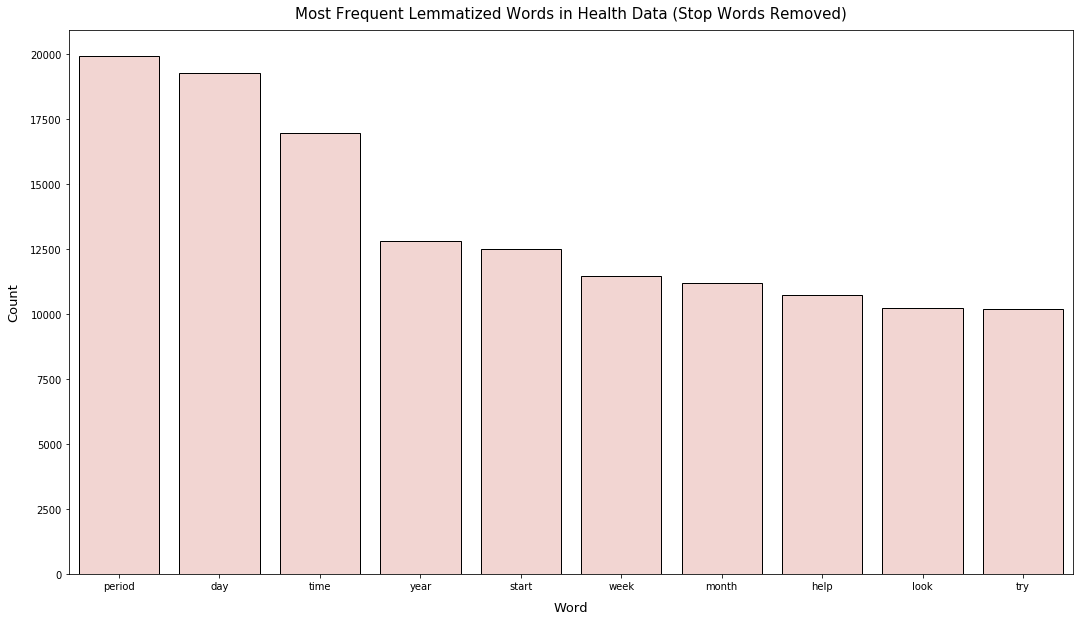

In [173]:
plot_top_words(lemmas_health_word_counts, 
               title = 'Most Frequent Lemmatized Words in Health Data (Stop Words Removed)',
               color = blush)

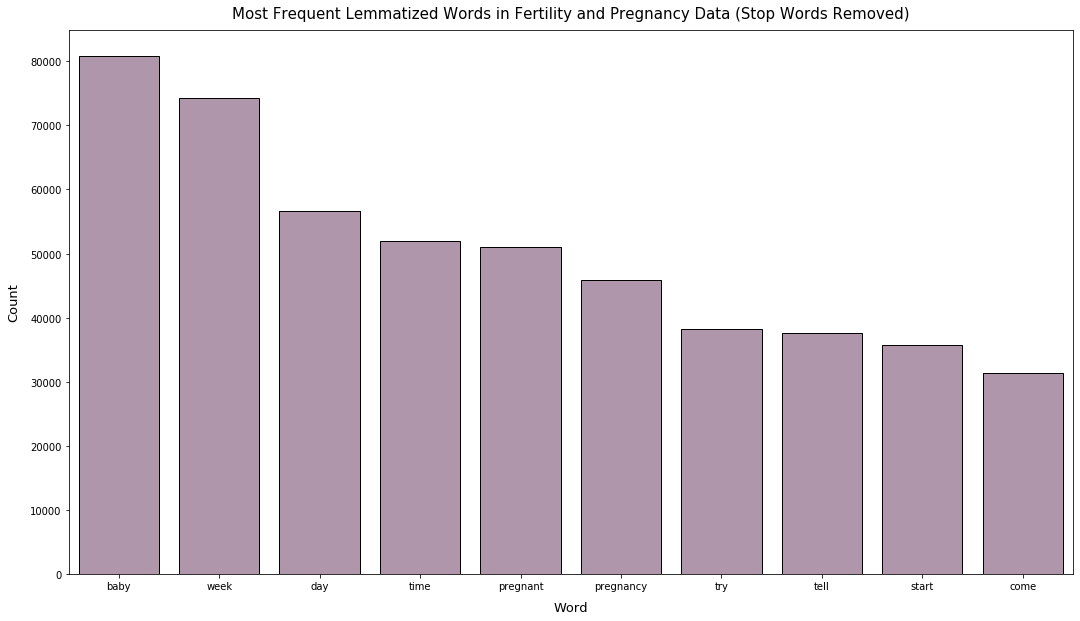

In [174]:
plot_top_words(lemmas_obsgyn_word_counts, 
               title = 'Most Frequent Lemmatized Words in Fertility and Pregnancy Data (Stop Words Removed)',
               color = dark_purple)

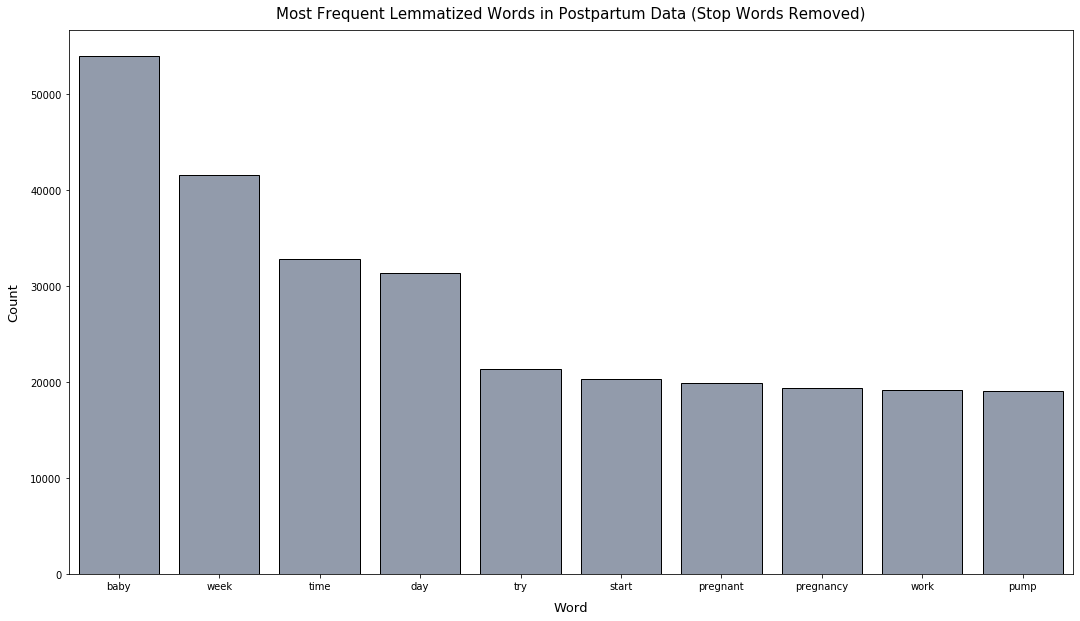

In [175]:
plot_top_words(lemmas_pospar_word_counts, 
               title = 'Most Frequent Lemmatized Words in Postpartum Data (Stop Words Removed)',
               color = warm_grey)

#### Bigrams

In [176]:
lemmas_health_bigrams = get_word_vector(lemmas_health_corpus, ngrams = (2,2), stopwords = full_stop_words)
lemmas_obsgyn_bigrams = get_word_vector(lemmas_obsgyn_corpus, ngrams = (2,2), stopwords = full_stop_words)
lemmas_pospar_bigrams = get_word_vector(lemmas_pospar_corpus, ngrams = (2,2), stopwords = full_stop_words)

lemmas_health_bigrams_counts = get_word_sums(lemmas_health_bigrams)
lemmas_obsgyn_bigrams_counts = get_word_sums(lemmas_obsgyn_bigrams)
lemmas_pospar_bigrams_counts = get_word_sums(lemmas_pospar_bigrams)

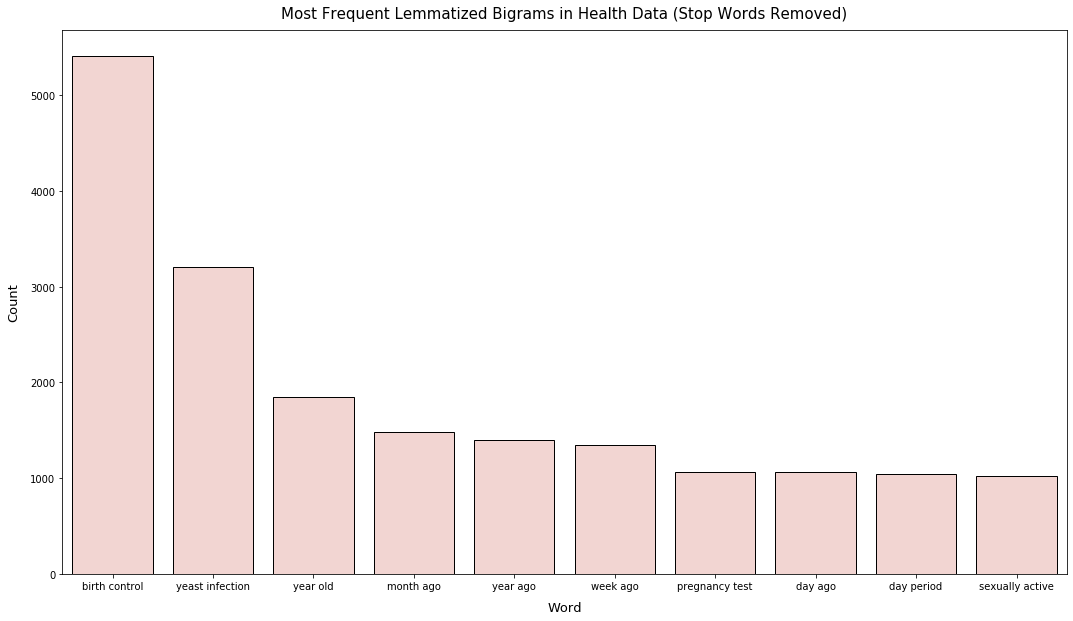

In [177]:
plot_top_words(lemmas_health_bigrams_counts, 
               title = 'Most Frequent Lemmatized Bigrams in Health Data (Stop Words Removed)',
               color = blush)

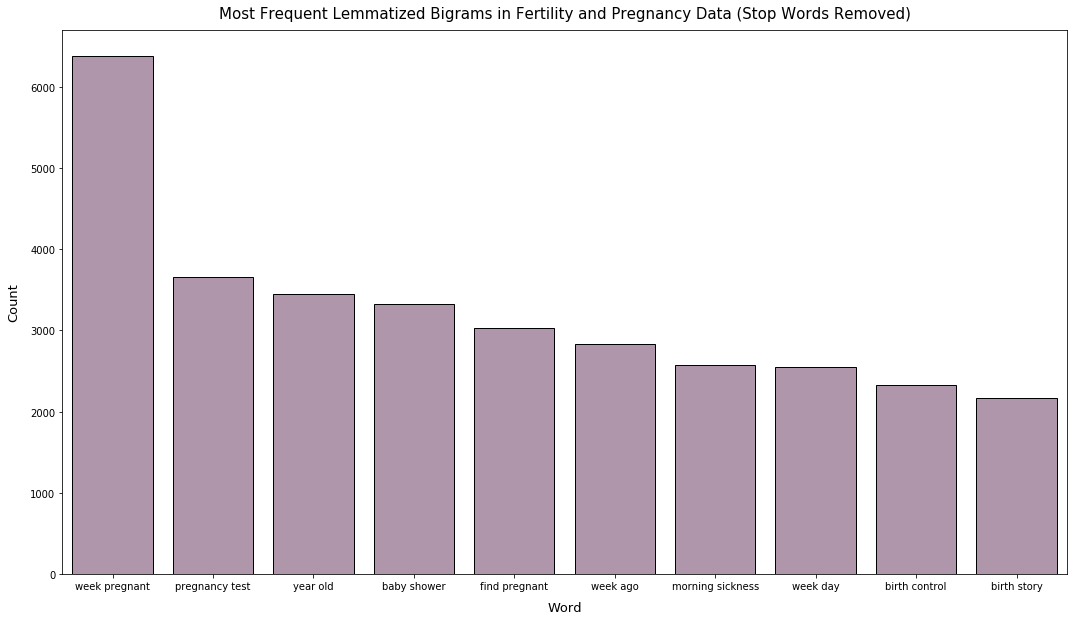

In [178]:
plot_top_words(lemmas_obsgyn_bigrams_counts, 
               title = 'Most Frequent Lemmatized Bigrams in Fertility and Pregnancy Data (Stop Words Removed)',
               color = dark_purple)

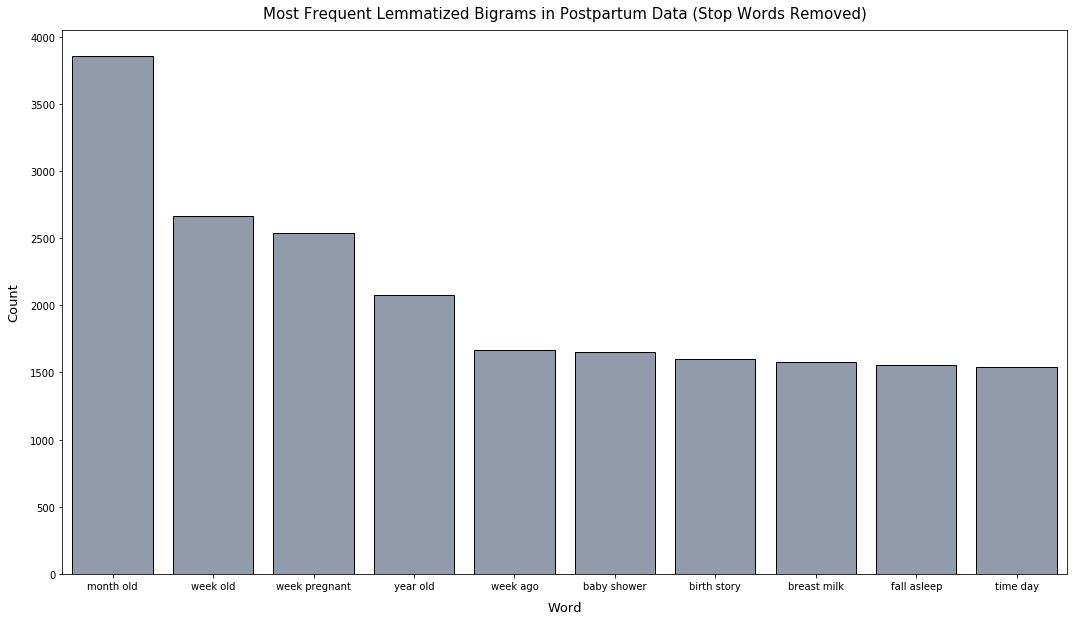

In [179]:
plot_top_words(lemmas_pospar_bigrams_counts, 
               title = 'Most Frequent Lemmatized Bigrams in Postpartum Data (Stop Words Removed)',
               color = warm_grey)

#### Trigrams

In [180]:
lemmas_health_trigrams = get_word_vector(lemmas_health_corpus, ngrams = (3,3), stopwords = full_stop_words)
lemmas_obsgyn_trigrams = get_word_vector(lemmas_obsgyn_corpus, ngrams = (3,3), stopwords = full_stop_words)
lemmas_pospar_trigrams = get_word_vector(lemmas_pospar_corpus, ngrams = (3,3), stopwords = full_stop_words)

lemmas_health_trigrams_counts = get_word_sums(lemmas_health_trigrams)
lemmas_obsgyn_trigrams_counts = get_word_sums(lemmas_obsgyn_trigrams)
lemmas_pospar_trigrams_counts = get_word_sums(lemmas_pospar_trigrams)

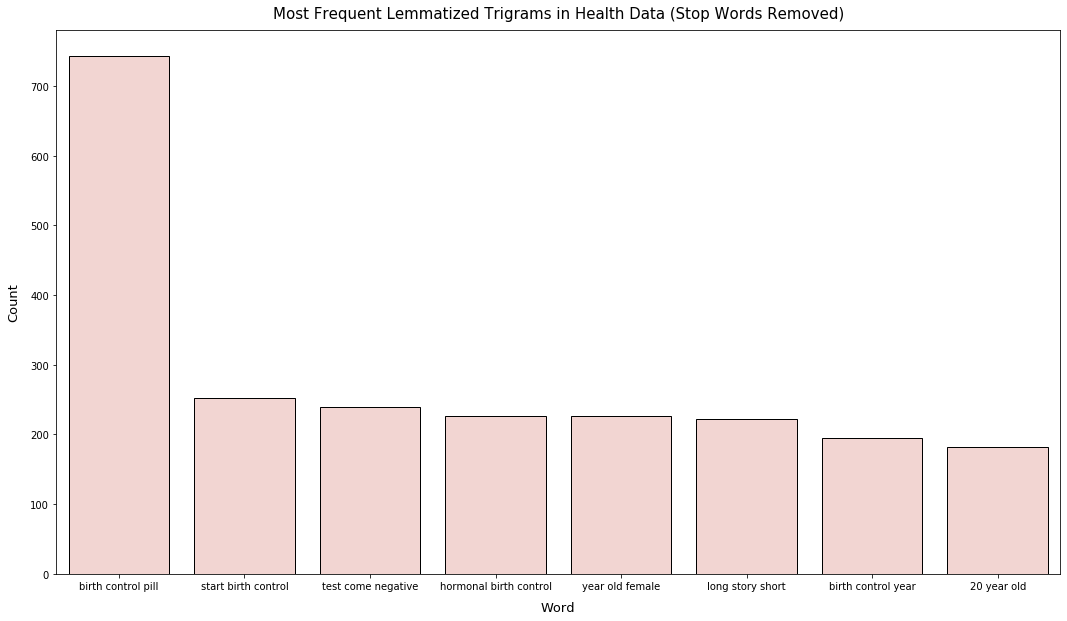

In [181]:
plot_top_words(lemmas_health_trigrams_counts, 
               title = 'Most Frequent Lemmatized Trigrams in Health Data (Stop Words Removed)',
               color = blush)

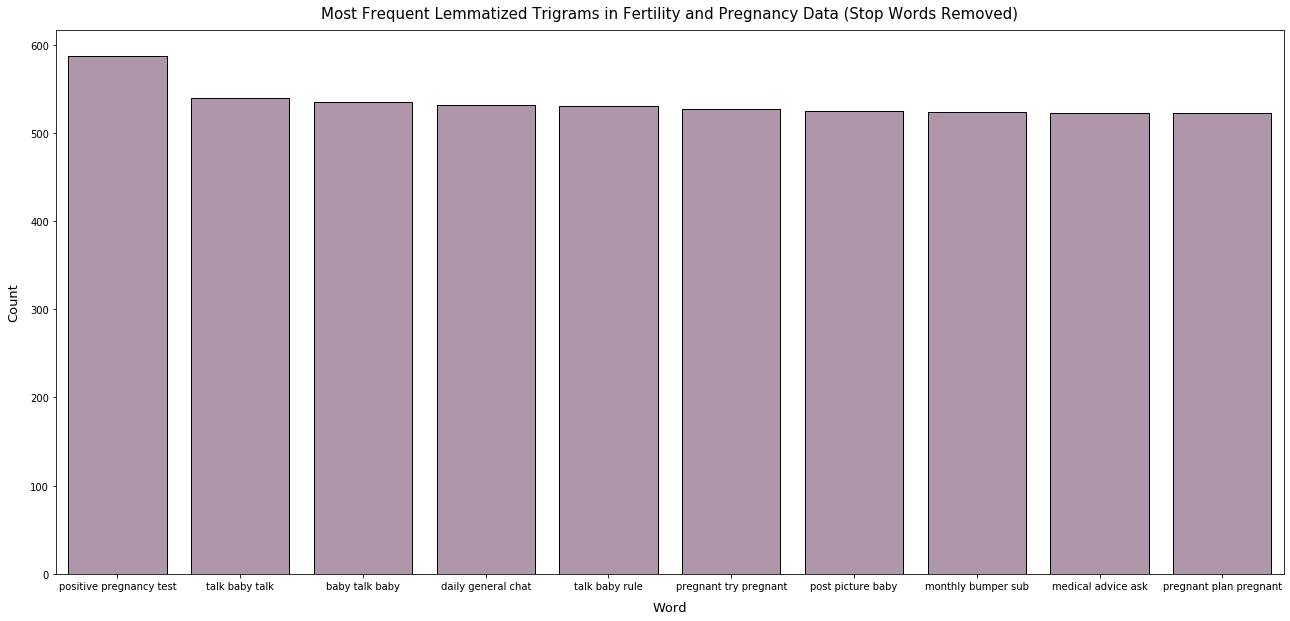

In [184]:
plot_top_words(lemmas_obsgyn_trigrams_counts, 
               title = 'Most Frequent Lemmatized Trigrams in Fertility and Pregnancy Data (Stop Words Removed)',
               color = dark_purple,
               size = (22, 10))

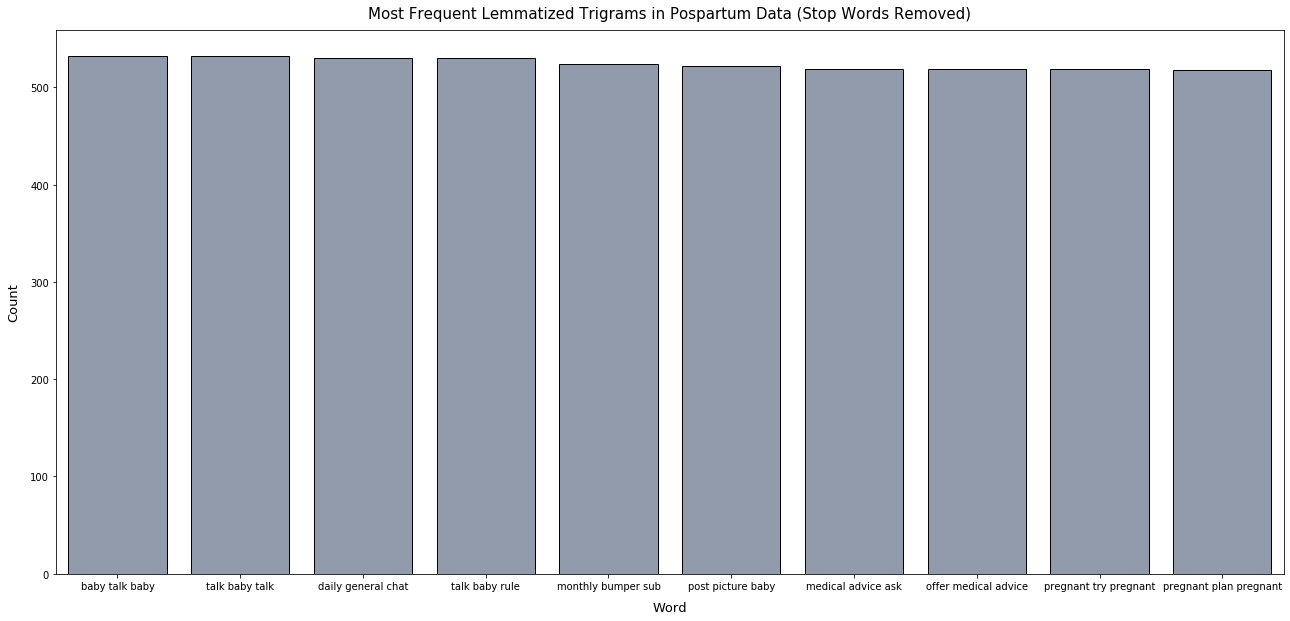

In [185]:
plot_top_words(lemmas_pospar_trigrams_counts, 
               title = 'Most Frequent Lemmatized Trigrams in Pospartum Data (Stop Words Removed)',
               color = warm_grey,
               size = (22, 10))

### Sentiment Analysis

In [190]:
sent_anal = SentimentIntensityAnalyzer()

In [202]:
def analyze_sentiment(df, column, new_column = 'sentiment_score', score = 'compound'):
    sentiment_scores = [sent_anal.polarity_scores(post)[score] for post in df[column]]
    df[new_column] = sentiment_scores
    return df.head()

In [ ]:
def get_negativity_score(df, column):

In [198]:
analyze_sentiment(health, 'total_text')

,index,subreddit,author,timestamp,total_text,word_count,lemma_tokens,sentiment_score
0,0,WomensHealth,thecrazedbunny,2020-08-07,Been to the clinic twice and they don’t know w...,382,be clinic twice wrong . help ! so -PRON- probl...,0.7246
1,1,WomensHealth,Help-Me-Already,2020-08-07,Period going on for 14 days today. Help!! Hi g...,200,period 14 day today . help ! ! hi guy . -PRON-...,-0.5209
2,2,WomensHealth,blueberrydoe,2020-08-07,Question about birth control - advice apprecia...,255,question birth control - advice appreciate ! h...,-0.8822
3,3,WomensHealth,TheTinyOne23,2020-08-07,Yeast infection vs. Cytolytic Vaginosis? Hi ev...,402,yeast infection vs. cytolytic Vaginosis ? hi !...,0.9823
4,4,WomensHealth,BabyFaceIT,2020-08-07,Virgin concerned about transvaginal ultrasound...,83,Virgin concerned transvaginal ultrasound -PRON...,0.2495


In [199]:
analyze_sentiment(obsgyn, 'total_text')

,index,subreddit,author,timestamp,total_text,word_count,lemma_tokens,sentiment_score
0,0,TryingForABaby,lastput1,2020-08-07,Adding to the kitchen sink approach: I just bo...,81,add kitchen sink approach : -PRON- buy menstru...,0.8158
1,1,TryingForABaby,ParkingFrosting4,2020-08-07,Has anyone used/or currently an app to track t...,66,have / currently app track ovulation ? -PRON- ...,-0.2163
2,2,TryingForABaby,MinimalTa1886,2020-08-07,Invited to my first “virtual” baby shower I do...,178,"invite "" virtual "" baby shower -PRON- -PRON- t...",0.7544
3,3,TryingForABaby,amma017,2020-08-07,Constantly testing during the TWW? I know it's...,84,constantly test TWW ? -PRON- hard test constan...,0.7703
4,4,TryingForABaby,bethrowinaway,2020-08-07,When do I actually ovulate? I’ve been tracking...,118,when -PRON- actually ovulate ? -PRON- track cy...,0.9084


In [200]:
analyze_sentiment(pospar, 'total_text')

,index,subreddit,author,timestamp,total_text,word_count,lemma_tokens,sentiment_score
0,0,BabyBumps,All_Hail_CC,2020-08-07,Question about bottles I'm researching baby bo...,43,question bottle -PRON- research baby bottle tr...,0.1779
1,1,BabyBumps,waterfallsummer,2020-08-07,Anyone else getting that generation gap judgem...,137,anyone get generation gap judgement ? aunt- -P...,0.8043
2,3,BabyBumps,mkokit1,2020-08-07,Insurance perks. Hello All we are expecting ou...,49,insurance perk . hello all expect mid oct BCBS...,0.0000
3,6,BabyBumps,denisemescudi,2020-08-07,37 weeks and extra moody Is just me or do thes...,76,37 week extra moody be week moody . -PRON- -PR...,0.8131
4,7,BabyBumps,malinjl36,2020-08-07,FTM Breastfeeding question Hey folks!FTM mom h...,97,FTM Breastfeeding question Hey folks!FTM mom ....,0.9542


In [204]:
dfs = [health, obsgyn, pospar]

for df in dfs:
    analyze_sentiment(df, 'total_text', 'negativity_score', score = 'neg')